# EMERGE: Constraining observation timescales of merging galaxies
##### About:
This notebook is intended to provide the scripts necessary to reproduce the key results shown [here](https://ui.adsabs.harvard.edu/abs/2020arXiv200102687O/abstract). I omit plots that include data and results of other works.

##### Data:
The data necessary to reproduce these results can be found [here](http://www.usm.uni-muenchen.de/emerge/data/galtrees/hdf5/). This data is produced using the code [EMERGE](http://www.usm.uni-muenchen.de/emerge/)

##### Code:
To run this notebook you will also need to install my personal library of analysis tools [galaxybox](https://github.com/jaoleary/galaxybox). If there are questions regarding the usage of these tools please consult that repository directly...or contact me.

##### Discalimer:
This notebook relies on publicly available data and codes, I cannot gurantee that updates to either of this won't result in a change to the results shown in this notebook or the associated paper. If for some reason you are unable to run this notebook or if you find some error **please** contact me.

# RUN THESE CELLS FIRST

## IMPORT LIBRARIES

In [1]:
from galaxybox_dev import sim_managers as gb
from galaxybox_dev.plot.emerge_plot import plot_stats_clustering

# plotting
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
from matplotlib import container
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#astropy
from astropy import cosmology as apcos
from astropy import constants as apconst
import astropy.units as apunits

#halotools
from halotools.mock_observables import wp

# scipy
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic
import scipy.interpolate as interpolate
import scipy.integrate as integrate
from scipy.spatial import ckdtree

# other
import os
import pandas as pd
import numpy as np
from multiprocessing import Pool
from jupyterthemes import jtplot # This is not a necessary library. But im a sucker for dark themes
from tqdm.auto import tqdm
import h5py
import warnings
warnings.filterwarnings("ignore")

## PLOTTING DEFAULTS

In [2]:
jtplot.reset()
plt.rcParams.update({'axes.linewidth' : 2,
                     'xtick.labelsize' : 16,
                     'xtick.major.width' : 2,
                     'xtick.major.size'  : 6,
                     'xtick.minor.width'  : 1,
                     'xtick.minor.size'  : 3,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.labelsize' : 16,
                     'ytick.major.width' : 2,
                     'ytick.major.size'  : 6,
                     'ytick.minor.width'  : 1,
                     'ytick.minor.size'  : 3,
                     'ytick.right' : True,
                     'ytick.direction' : 'in',
                     'font.family':'serif',
                     'mathtext.fontset': 'cm'})

## IMPORT DATA

In [3]:
P200 = gb.Universe(param_path = '../../Programs/emerge-dev/parameterfiles/P200.param', sim_type = 'emerge', include=['trees', 'survey','statistics'])
P200.galaxy.sort_index() # sort the galaxy trees by ID.
P200.add_figdir(P200.out_dir+'/obs_timescale_figures/') # this is optional, just make a directory to save all of the figures to.

Loading statistics:
/home/joleary/Programs/emerge-dev/output/P200/statistics.h5


In [4]:
# construct some new lightcone catalogs
P200.galaxy.survey.new_observation(group='GOODS-S', name='wide', m=8, n=5, min_z=0, max_z=5, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=42)
P200.galaxy.survey.new_observation(group='GOODS-S', name='deep', m=9, n=6, min_z=0, max_z=5, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=42)

P200.galaxy.survey.new_observation(group='GOODS-N', name='wide', m=8, n=5, min_z=0, max_z=5, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=24)
P200.galaxy.survey.new_observation(group='GOODS-N', name='deep', m=9, n=6, min_z=0, max_z=5, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=24)
P200.galaxy.survey.new_observation(group='COSMOS', name='wide', m=10, n=4, min_z=0, max_z=5, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=25)
P200.galaxy.survey.new_observation(group='UDS', name='wide', m=9, n=4, min_z=0, max_z=5, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=26)
P200.galaxy.survey.new_observation(group='EGS', name='wide', m=13, n=3, min_z=0, max_z=5, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=27)
P200.galaxy.survey.new_observation(group='SDSS', name='DR4', m=1.10636, n=1.10636, min_z=0.03, max_z=0.05, min_mstar=8, fuzzy_bounds=True, randomize=True, seed=28)
P200.galaxy.survey.save()

# snyder-like cones.
#P200.galaxy.survey.new_observation(group='Snyder16', name='wide-A', m=6, n=7, min_z=0, max_z=4, min_mstar=9, fuzzy_bounds=True, randomize=True, seed=15)
#P200.galaxy.survey.new_observation(group='Snyder16', name='wide-B', m=6, n=7, min_z=0, max_z=4, min_mstar=9, fuzzy_bounds=True, randomize=True, seed=16)
#P200.galaxy.survey.new_observation(group='Snyder16', name='wide-C', m=6, n=7, min_z=0, max_z=4, min_mstar=9, fuzzy_bounds=True, randomize=True, seed=17)

#P200.galaxy.survey.new_observation(group='Snyder16', name='thin-A', m=10, n=11, min_z=0, max_z=4, min_mstar=9, fuzzy_bounds=True, randomize=True, seed=18)
#P200.galaxy.survey.new_observation(group='Snyder16', name='thin-B', m=10, n=11, min_z=0, max_z=4, min_mstar=9, fuzzy_bounds=True, randomize=True, seed=19)
#P200.galaxy.survey.new_observation(group='Snyder16', name='thin-C', m=10, n=11, min_z=0, max_z=4, min_mstar=9, fuzzy_bounds=True, randomize=True, seed=20)
#P200.galaxy.survey.save()

# load previously saved lightcone catalogs
#P200.galaxy.survey.load_group(group='GOODS-S', link_trees=True)
#P200.galaxy.survey.load_group(group='GOODS-N', link_trees=True)
#P200.galaxy.survey.load_group(group='COSMOS', link_trees=True)
#P200.galaxy.survey.load_group(group='UDS', link_trees=True)
#P200.galaxy.survey.load_group(group='EGS', link_trees=True)
#P200.galaxy.survey.load_group(group='SDSS', link_trees=True)
#P200.galaxy.survey.load_group(group='Snyder16', link_trees=True)

In [5]:
observations = [('GOODS-S', 'wide', 5),
                ('GOODS-N', 'wide', 5),
                ('COSMOS', 'wide', 5),
                ('UDS', 'wide', 5),
                ('EGS', 'wide', 5),
                ('GOODS-S', 'deep', 5),
                ('GOODS-N', 'deep', 5),
                ('SDSS', 'DR4', [0.03, 0.05])]
for i, obs in enumerate(observations):
    group, name, redshift_bins = obs
    P200.galaxy.survey.obs(group=group, name=name).pairs = pd.read_hdf(pair_path, key=group+'/'+name)


NameError: name 'pair_path' is not defined

## DEFINE FUNCTIONS

In [5]:
# a wrapper function to parallelize the mergeing_time method
def parallel_merging_time(ipair):
    igal_1 = ipair[0]
    igal_2 = ipair[1]
    return P200.galaxy.merging_time(igal_1, igal_2)


def get_pairs(observation, num_procs=1):
    # a pair catalog for each slice of the cone
    pairs = [None]*(len(observation.redshift_bins)-1)
    
    #loop over each cone slice
    for i in tqdm(range(len(pairs))):
        pairs[i] = pd.DataFrame(columns=['slice', 'dok_main', 'dok_minor','cone_id_main', 'cone_id_minor', 'tree_id_main', 'tree_id_minor', 'radius', 'dz', 'MR', 'tdf'])
        
        pair_dok = np.array(observation.distmat[i].nonzero()).T
        galaxies = observation.list(slice=i)
        # get the properties for each pair
        G1_prop = galaxies.iloc[pair_dok[:,0]]
        G2_prop = galaxies.iloc[pair_dok[:,1]]

        MR = (G1_prop['Stellar_mass'].values-G2_prop['Stellar_mass'].values)
        MR_mask = (MR>=0) & (MR<1)
        MR = MR[MR_mask]
        MR = 10**MR
        pairs[i]['MR'] = MR

        pair_dok = pair_dok[MR_mask]
        pairs[i][['dok_main','dok_minor']] = pair_dok

        G1_prop = G1_prop[MR_mask]
        G2_prop = G2_prop[MR_mask]

        dz = np.abs(G1_prop['Redshift_obs'].values - G2_prop['Redshift_obs'].values)
        pairs[i]['dz'] = dz

        G1_index = G1_prop.index.values
        G2_index = G2_prop.index.values
        pairs[i][['cone_id_main', 'cone_id_minor']] = np.array([G1_index, G2_index]).T

        G1_index = G1_prop.Tree_ID.values
        G2_index = G2_prop.Tree_ID.values
        pairs[i][['tree_id_main', 'tree_id_minor']] = np.array([G1_index, G2_index]).T
        pair_id = [(G1_index[k], G2_index[k]) for k in range(len(G1_index))]
        
        radius = np.zeros(len(pairs[i]['dok_main']))
        for j in range(len(pairs[i]['dok_main'])):
            dok_1 = pairs[i].iloc[j]['dok_main']
            dok_2 = pairs[i].iloc[j]['dok_minor']
            radius[j] = observation.distmat[i][(dok_1, dok_2)]
        pairs[i]['radius'] = radius
        pairs[i]['slice'] = i

        with Pool(processes=num_procs) as pool:
            # if you are in desperate need of another loading bar use imap
            #pairs[i]['tdf'] = np.array(list(tqdm(pool.imap(parallel_merging_time, pair_id),total=len(pair_id))))
            pairs[i]['tdf'] = np.array(list(pool.map(parallel_merging_time, pair_id)))
        
    return pd.concat(pairs)

# DARK MATTER SIMULATIONS AND EMERGE

## High redshift clustering

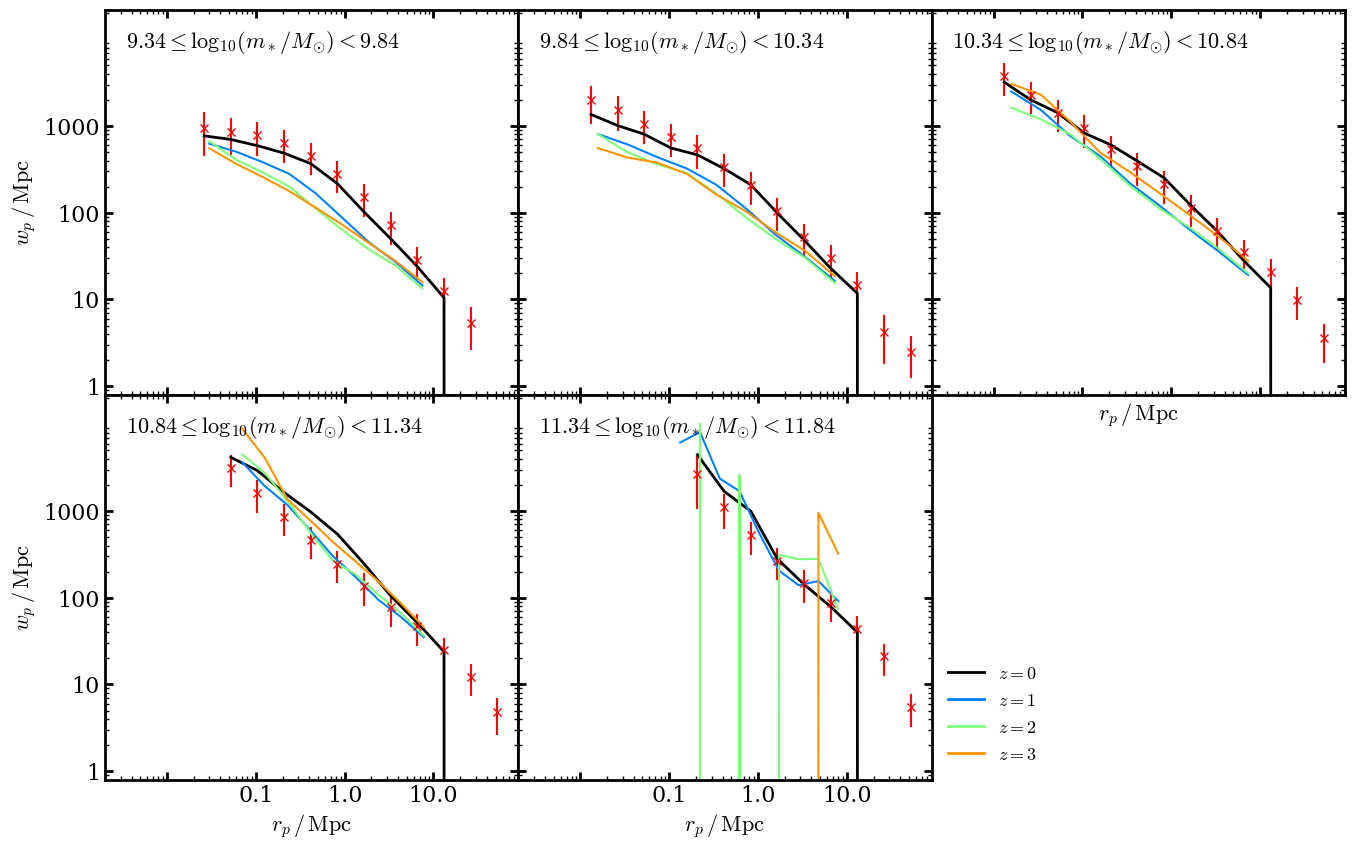

In [6]:
handles = []
ax = plot_stats_clustering(P200.statistics.Clustering, observations=True, color='k', lw=2)
handles += [Line2D([0], [0], color='k', lw=2, ls = '-', label='$z=0$')]

mass_bins = np.array([9.34, 9.84, 10.34, 10.84, 11.34, 11.84])
pi_max = 10/P200.cosmology.h
rp_range = [(0.02, 30),
            (0.01, 60),
            (0.01, 60),
            (0.05, 60),
            (0.1, 60)]
redshifts = [1, 2, 3]
color = [plt.cm.jet((1)/float(4)), plt.cm.jet((2)/float(4)), plt.cm.jet((3)/float(4))]
for j, z in enumerate(redshifts):
    handles += [Line2D([0], [0], color=color[j], lw=2, ls = '-', label='$z={}$'.format(z))]
    for i, axi in enumerate(ax.reshape(-1)[:-1]):
        rmin = np.log10(rp_range[i][0])
        rmax = np.log10(rp_range[i][1])
        rp_bins = np.logspace(rmin,1,10)
        rpc = (rp_bins[:-1]+rp_bins[1:])/2
        min_mass = mass_bins[i]
        max_mass = mass_bins[i+1]
        coords = P200.galaxy.list(min_mstar=min_mass, max_mstar=max_mass,z=z)[['X_pos', 'Y_pos', 'Z_pos']].values
        if len(coords) > 0:
            xi = wp(coords, rp_bins, pi_max, period=P200.BoxSize/P200.cosmology.h)
            axi.plot(rpc,xi, color=color[j])

ax[-1,-1].axis('off')
ax[0,2].set_xlabel('$r_p \, / \, \mathrm{Mpc}$', size=16)
ax[0,0].texts[0].remove()
ax[0,0].annotate('$9.34 \leq \log_{10}(m_*/M_{\odot}) < 9.84$', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top')
ax[0,1].texts[0].remove()
ax[0,1].annotate('$9.84 \leq \log_{10}(m_*/M_{\odot}) < 10.34$', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top')
ax[0,2].texts[0].remove()
ax[0,2].annotate('$10.34 \leq \log_{10}(m_*/M_{\odot}) < 10.84$', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top')
ax[1,0].texts[0].remove()
ax[1,0].annotate('$10.84 \leq \log_{10}(m_*/M_{\odot}) < 11.34$', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top')
ax[1,1].texts[0].remove()
ax[1,1].annotate('$11.34 \leq \log_{10}(m_*/M_{\odot}) < 11.84$', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top')

ax[-1,-1].legend(handles=handles, frameon=False, loc='lower left', prop={'size':13})


plt.show()

# Compute pair fractions

In [ ]:


# first bin then setup the distance matrix for each observation
#                ('Snyder16', 'wide-A', snyder_bins),
#               ('Snyder16', 'thin-A', snyder_bins),
#snyder_bins = np.array([0.35209458, 0.4744055 , 0.61936295, 0.79559731, 1.01710787, 1.30833942, 1.71656705, 2.3482294 , 3.51241823, 3.99999998])
pair_path = os.path.join(P200.out_dir,'lightcone_pairs.h5')
observations = [('GOODS-S', 'wide', 10),
                ('GOODS-N', 'wide', 10),
                ('COSMOS', 'wide', 10),
                ('UDS', 'wide', 10),
                ('EGS', 'wide', 10),
                ('GOODS-S', 'deep', 10),
                ('GOODS-N', 'deep', 10),
                ('SDSS', 'DR4', [0.03, 0.05])]
for i, obs in enumerate(observations):
    group, name, redshift_bins = obs

    observation = P200.galaxy.survey.obs(group=group, name=name)
    observation.set_cone_slice(bins=redshift_bins)
    observation.set_distance_matrix(max_distance=0.1, comoving=False)  
    observation.pairs = get_pairs(observation, num_procs=8)
    observation.pairs.to_hdf(pair_path, key=group+'/'+name, data_columns=True)
    

[52. 67. 63. 54. 39.]
[67. 98. 48. 47. 41.]
[51. 63. 73. 77. 54.]
[ 91. 152. 116. 111.  13.]
[66. 79. 84. 73. 39.]
[27. 31. 16. 21.  8.]
[11. 30. 44. 35.  9.]
[316.]


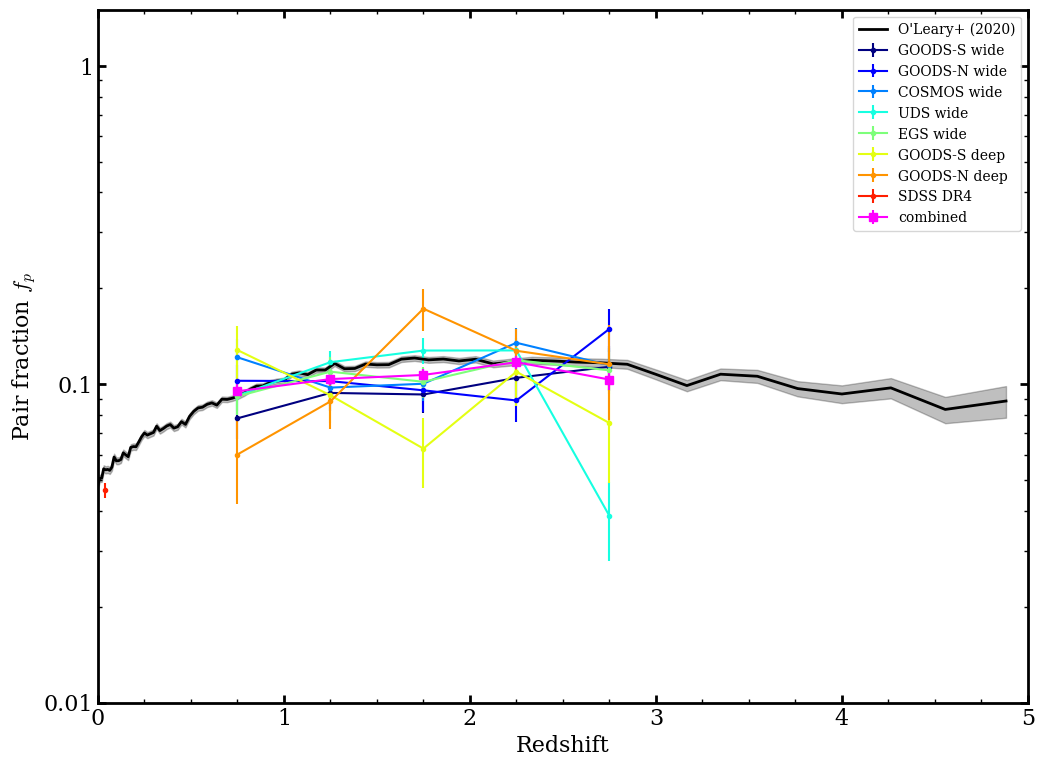

In [134]:
min_mstar, max_mstar = 10.3, np.inf
r_min, r_max = 0.005, 0.05
min_MR, max_MR = 1, 4
dv_max = 500

fig, ax = plt.subplots(figsize=(12,9))
ax.set_yscale('log')
ax.set_xlim(0,5)
ax.set_ylim(0.01, 1.5)
ax.set_ylabel('Pair fraction $f_{p}$', size=16)
ax.set_xlabel('Redshift', size=16)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.25, 4.5+75, 0.25)))

color = [plt.cm.jet(i/len(observations)) for i in range(len(observations))]

pairs = pd.read_hdf('./pair_counts.h5', key='P4')

z=pairs['redshift']
Np = (pairs['rp:50']-pairs['rp:5'])
Ng = pairs['N_gal']
fp = Np/Ng
err = fp/np.sqrt(Np)
ax.plot(z, fp,color='k', lw=2,label='O\'Leary+ (2020)')
ax.fill_between(z,fp+err,fp-err,alpha=0.25, color='k')

Ngc = np.zeros(5)
Npc = np.zeros(5)

for i, obs in enumerate(observations):
    group, name, redshift_bins = obs
    observation = P200.galaxy.survey.obs(group=group, name=name)
    bins = observation.redshift_bins
    z = (bins[:-1] + bins[1:])/2
    
    pairs = observation.pairs
    Np = np.zeros(len(pairs.slice.unique()))
    Ng = np.zeros(len(pairs.slice.unique()))
    for j in range(len(Np)):
        zmask = pairs.slice == j
        mstar = observation.list(index = pairs.loc[zmask]['cone_id_main'].values)['Stellar_mass'].values
        mstar_mask = (mstar >= min_mstar) & (mstar < max_mstar)
        redshift = observation.list(index = pairs.loc[zmask]['cone_id_main'].values)['Redshift'].values 
        dz_mask = (pairs.loc[zmask]['dz'] <= dv_max*(1+redshift)/apconst.c.to('km/s').value)
        radius_mask = (pairs.loc[zmask]['radius'] >= r_min) & (pairs.loc[zmask]['radius'] < r_max)
        MR_mask = (pairs.loc[zmask]['MR'] >= 1) & (pairs.loc[zmask]['MR'] < 4)
        Np[j] = (mstar_mask & dz_mask & radius_mask & MR_mask).sum()
        Ng[j] = len(observation.list(slice=[j], min_mstar=min_mstar, max_mstar=max_mstar)) 
    
    if group is not 'SDSS':
        Npc += Np
        Ngc += Ng
    fp = Np/Ng
    print(Np)
    err = fp/np.sqrt(Np)
    ax.errorbar(z, fp, yerr=err, marker='.', color=color[i],label=group+' '+name)
    
    
fp = Npc/Ngc
err = fp/np.sqrt(Npc)
observation = P200.galaxy.survey.obs(group='GOODS-S', name='wide')
bins = observation.redshift_bins
z = (bins[:-1] + bins[1:])/2
ax.errorbar(z, fp, yerr=err, marker='s', color='magenta',label='combined')
    
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

plt.legend()
#plt.savefig(P200.fig_dir+'/pair_fraction.pdf',bbox_inches='tight')
plt.show()

## Compute correction factor

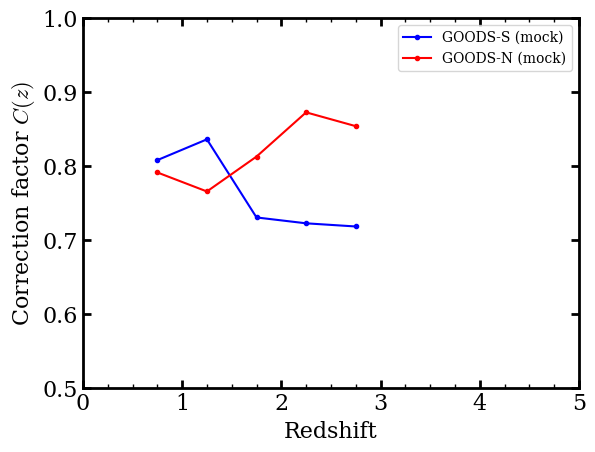

In [11]:
fig, ax = plt.subplots()

ax.set_xlim(0,5)
ax.set_ylim(0.5, 1.)
ax.set_ylabel('Correction factor $C(z)$', size=16)
ax.set_xlabel('Redshift', size=16)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.25, 4.5+75, 0.25)))

for i, obs in enumerate(observations):
    group, name = obs
    bins = P200.galaxy.survey.obs(group=group, name=name).redshift_bins
    z = (bins[:-1] + bins[1:])/2
    pairs = P200.galaxy.survey.obs(group=group, name=name).get_pairs(r_min=0.005, r_max=0.05, min_mstar=10.3)
    C=np.array([None]*len(pairs))
    
    for j, cone_pairs in enumerate(pairs):
        Tree_ID_1 = P200.galaxy.survey.obs(group=group, name=name).list(index=np.array(cone_pairs)[:,0]).Tree_ID.values
        Tree_ID_2 = P200.galaxy.survey.obs(group=group, name=name).list(index=np.array(cone_pairs)[:,1]).Tree_ID.values

        tree_pairs = [(Tree_ID_1[k], Tree_ID_2[k]) for k in range(len(cone_pairs))]

        count = 0
        for p in tree_pairs:
            igal_1 = p[0]
            igal_2 = p[1]
            desc = P200.galaxy.common_descendant(igal_1, igal_2)
            #print(desc)
            if desc > 0:
                count += 1
        C[j] = count/len(cone_pairs)
    ax.plot(z, C, marker='.', color=color[i],label=group+' (mock)')
    
plt.legend()
plt.savefig(P200.fig_dir+'/correction_factor.pdf',bbox_inches='tight')
plt.show()

## Compute observation timescales

# SCRATCH

In [12]:
pairs = P200.galaxy.survey.obs(group=group, name=name).get_pairs(r_min=0.005, r_max=0.05, min_mstar=10.3)

In [13]:
cone_pairs = pairs[0]
Tree_ID_1 = P200.galaxy.survey.obs(group=group, name=name).list(index=np.array(cone_pairs)[:,0]).Tree_ID.values
Tree_ID_2 = P200.galaxy.survey.obs(group=group, name=name).list(index=np.array(cone_pairs)[:,1]).Tree_ID.values
tree_pairs = [(Tree_ID_1[k], Tree_ID_2[k]) for k in range(len(cone_pairs))]

In [16]:
for i, p in enumerate(tree_pairs):
    igal_1 = p[0]
    igal_2 = p[1]
    time = P200.galaxy.merging_time(igal_1, igal_2)
    desc = P200.galaxy.common_descendant(igal_1, igal_2)
    print(i, desc, time)

0 7732816 10.306140899658203
1 7895823 8.55552864074707
2 0 0
3 0 0
4 11779425 9.280662536621094
5 0 0
6 11813853 9.92251205444336
7 0 0
8 11943346 11.901845932006836
9 0 0
10 6012007 8.51541519165039
11 6383623 9.322725296020508
12 6583843 11.219823837280273
13 0 0
14 2428159 8.208784103393555
15 13717202 8.469588279724121
16 3968029 8.0701265335083
17 3968029 9.237396240234375
18 4015066 8.302865982055664
19 6328370 9.128304481506348
20 6372839 7.394207000732422
21 0 0
22 7765866 7.206885814666748
23 7807708 7.708242416381836
24 11443212 8.09262752532959
25 11443212 11.89048957824707
26 11443212 13.357749938964844
27 11805396 7.101747989654541
28 0 0
29 114500 12.042020797729492
30 114500 12.042020797729492
31 180197 7.074894905090332
32 7732816 7.379810810089111
33 7732816 10.306140899658203
34 7732816 10.306140899658203
35 2323975 7.808207988739014
36 9799470 12.983166694641113
37 9891080 9.879632949829102
38 9907979 6.9576640129089355
39 9959546 8.338340759277344
40 9967349 8.0622

In [80]:
P200.galaxy.survey.obs(group=group, name=name).pairs[0]['dok']

array([[ 750,    0],
       [   2,    3],
       [ 868,    6],
       ...,
       [ 353, 2263],
       [ 354, 2263],
       [1683, 2266]], dtype=int32)

In [24]:
igal_1, igal_2 = tree_pairs[34]
print(igal_1, igal_2)

7733002 7733197


In [23]:
inode_1 = P200.galaxy.next_node(igal_1)
inode_2 = P200.galaxy.next_node(igal_1)
print(inode_1, inode_2)

7732856 7732856


2324014 2324014


In [26]:
while inode_1 != inode_2:
    # step forward on the galaxy that is at an earlier epoch
    if scale_1 < scale_2:
        gal_1 = P200.galaxy.next_node(inode_1, id_only=False)
        inode_1 = gal_1.name
        scale_1 = gal_1.Scale

    if scale_2 < scale_1:
        gal_2 = P200.galaxy.next_node(inode_2, id_only=False)
        inode_2 = gal_2.name
        scale_2 = gal_2.Scale
print(inode_1, inode_2)

7732856 7732856


In [23]:
P200.galaxy.tree(7732838)

Scale  Up_ID  Desc_ID  Main_ID   MMP_ID  Coprog_ID  Leaf_ID  \
ID                                                                     
7732838   0.78      0  7732837  7732838  7732839          0  7733390   
7732839   0.77      0  7732838  7732839  7732840    7733175  7733174   
7732840   0.76      0  7732839  7732840  7732841          0  7733174   
7732841   0.75      0  7732840  7732841  7732842          0  7733174   
7732842   0.74      0  7732841  7732842  7732843          0  7733174   
...        ...    ...      ...      ...      ...        ...      ...   
7733386   0.24      0  7733385  7733386  7733387          0  7733390   
7733387   0.23      0  7733386  7733387  7733388          0  7733390   
7733388   0.22      0  7733387  7733388  7733389          0  7733390   
7733389   0.21      0  7733388  7733389  7733390          0  7733390   
7733390   0.20      0  7733389  7733390        0          0  7733390   

         Original_ID  Num_prog  MMP  ...      X_pos     Y_pos      Z_pos  \
ID                                   ...                                   
7732838     10687483         2    1  ...  94.753662  3.534862   7.090311   
7732839     10540690         1    1  ...  94.729897  3.578027   7.141469   
7732840     10393471         1    1  ...  94.705673  3.626117   7.192729   
7732841     10245193         1    1  ...  94.690079  3.674620   7.248164   
7732842     10096153         1    1  ...  94.667488  3.727533   7.308863   
...              ...       ...  ...  ...        ...       ...        ...   
7733386      1603956         1    1  ...  93.986420  6.485798  12.181611   
7733387      1436775         1    1  ...  93.956970  6.570284  12.328816   
7733388      1274105         1    1  ...  93.919571  6.637325  12.461422   
7733389      1116642         1    1  ...  93.899269  6.748518  12.631057   
7733390       965921         0    1  ...  93.854492  6.801372  12.741896   

             X_vel       Y_vel       Z_vel        tdf        Age  Type  Flag  
ID                                                                            
7732838  80.459999 -199.580002 -246.850006  10.448819  10.448819     0     0  
7732839  65.260002 -204.720001 -239.210007  10.288908  10.288908     0     0  
7732840  87.320000 -224.070007 -263.279999  10.128458  10.128458     0     0  
7732841  81.589996 -220.850006 -275.179993   9.967490   9.967490     0     0  
7732842  87.930000 -224.779999 -258.130005   9.806028   9.806028     0     0  
...            ...         ...         ...        ...        ...   ...   ...  
7733386  62.419998 -138.210007 -279.140015   2.026123   2.026123     0     0  
7733387  64.160004 -142.580002 -266.359985   1.901974   1.901974     0     0  
7733388  66.099998 -135.550003 -249.820007   1.780284   1.780284     0     0  
7733389  59.240002 -135.820007 -241.070007   1.661139   1.661139     0     0  
7733390  66.209999 -131.369995 -227.669998   1.544630   1.544630     0     0  

[553 rows x 33 columns]

In [112]:
igal_1, igal_2 = 7732850, 7733186
merging_time(igal_1, igal_2)

(10.306140899658203, 'F', 7732838.0)

In [114]:
P200.galaxy.list(redshift='all', Desc_ID=7732838)

Scale    Up_ID  Desc_ID  Main_ID   MMP_ID  Coprog_ID  Leaf_ID  \
ID                                                                       
7732839   0.77        0  7732838  7732839  7732840    7733175  7733174   
7733175   0.77  7732839  7732838  7732839  7733176          0  7733390   

         Original_ID  Num_prog  MMP  ...      X_pos     Y_pos     Z_pos  \
ID                                   ...                                  
7732839     10540690         1    1  ...  94.729897  3.578027  7.141469   
7733175     18040964         1    0  ...  94.742867  3.568967  7.142544   

             X_vel       Y_vel       Z_vel        tdf        Age  Type  Flag  
ID                                                                            
7732839  65.260002 -204.720001 -239.210007  10.288908  10.288908     0     0  
7733175  65.260002 -204.720001 -239.210007  10.306141  10.288908     2     1  

[2 rows x 33 columns]

In [74]:
idx = 3
mb = np.arange(10)

In [102]:
max(1,3)

3

In [91]:
P200.galaxy.trees.keys()

Index(['Scale', 'Up_ID', 'Desc_ID', 'Main_ID', 'MMP_ID', 'Coprog_ID',
       'Leaf_ID', 'Original_ID', 'Num_prog', 'MMP', 'Halo_mass',
       'Halo_growth_rate', 'Halo_mass_peak', 'Scale_peak_mass', 'Stellar_mass',
       'SFR', 'Intra_cluster_mass', 'Stellar_mass_obs', 'SFR_obs',
       'Stellar_mass_root', 'Halo_radius', 'Concentration', 'Halo_spin',
       'X_pos', 'Y_pos', 'Z_pos', 'X_vel', 'Y_vel', 'Z_vel', 'tdf', 'Age',
       'Type', 'Flag'],
      dtype='object')

In [84]:
class MyClass:
    pass

def func(self):
    print("func")

MyClass.myMethod = func

In [87]:
from galaxybox_dev.helper_functions.functions import arg_parser
import inspect

In [90]:
inspect.getfullargspec(P200.galaxy.redshift_at_massfrac)[0]

['self', 'igal', 'frac']

In [19]:
observation.redshift_bins

array([0.5, 1. , 1.5, 2. , 2.5, 3. ])

In [136]:
def parallel_merging_time(ipair):
    igal_1 = ipair[0]
    igal_1 = ipair[1]
    return P200.galaxy.merging_time(igal_1, igal_2)

pairs = [None]*(len(observation.redshift_bins)-1)
i = 0
pairs[i] = {}

pair_dok = np.array(observation.distmat[i].nonzero()).T
galaxies = observation.list(slice=i)
# get the properties for each pair
G1_prop = galaxies.iloc[pair_dok[:,0]]
G2_prop = galaxies.iloc[pair_dok[:,1]]

MR = (G1_prop['Stellar_mass'].values-G2_prop['Stellar_mass'].values)
MR_mask = (MR>=0) & (MR<1)
MR = MR[MR_mask]
MR = 10**MR
pairs[i]['MR'] = MR

pair_dok = pair_dok[MR_mask]
pairs[i]['dok'] = pair_dok

G1_prop = G1_prop[MR_mask]
G2_prop = G2_prop[MR_mask]

dz = np.abs(G1_prop['Redshift_obs'].values - G2_prop['Redshift_obs'].values)
pairs[i]['dz'] = dz

G1_index = G1_prop.index.values
G2_index = G2_prop.index.values
pairs[i]['cone_id'] = np.array([G1_index, G2_index]).T

G1_index = G1_prop.Tree_ID.values
G2_index = G2_prop.Tree_ID.values
pairs[i]['tree_id'] = np.array([G1_index, G2_index]).T
pair_id = [(G1_index[k], G2_index[k]) for k in range(len(G1_index))]

#time = np.zeros(len(pairs[i]['tree_id']))
#for j, tdf in enumerate(tqdm(time)):
#    igal_1 = pairs[i]['tree_id'][j][0]
#    igal_2 = pairs[i]['tree_id'][j][1]
#    tdf = P200.galaxy.merging_time(igal_1, igal_2)
#    time[i] = tdf

#pairs[i]['tdf'] = time

num_procs=8
with Pool(processes=num_procs) as pool:
    pairs[i]['tdf'] = np.array(list(tqdm(pool.imap(parallel_merging_time, pair_id),total=len(pair_id))))
    #pairs[i]['tdf'] = np.array(list(pool.map(parallel_merging_time, pair_id)))





In [143]:
# a wrapper function to parallelize the mergeing_time method
def parallel_merging_time(ipair):
    igal_1 = ipair[0]
    igal_1 = ipair[1]
    return P200.galaxy.merging_time(igal_1, igal_2)

def get_pairs(observation, num_proc=1):
    # a pair catalog for each slice of the cone
    pairs = [None]*(len(observation.redshift_bins)-1)
    
    #loop over each cone slice
    for i in tqdm(range(len(pairs))):
        pairs[i] = {}
        
        pair_dok = np.array(observation.distmat[i].nonzero()).T
        galaxies = observation.list(slice=i)
        # get the properties for each pair
        G1_prop = galaxies.iloc[pair_dok[:,0]]
        G2_prop = galaxies.iloc[pair_dok[:,1]]

        MR = (G1_prop['Stellar_mass'].values-G2_prop['Stellar_mass'].values)
        MR_mask = (MR>=0) & (MR<1)
        MR = MR[MR_mask]
        MR = 10**MR
        pairs[i]['MR'] = MR

        pair_dok = pair_dok[MR_mask]
        pairs[i]['dok'] = pair_dok

        G1_prop = G1_prop[MR_mask]
        G2_prop = G2_prop[MR_mask]

        dz = np.abs(G1_prop['Redshift_obs'].values - G2_prop['Redshift_obs'].values)
        pairs[i]['dz'] = dz

        G1_index = G1_prop.index.values
        G2_index = G2_prop.index.values
        pairs[i]['cone_id'] = np.array([G1_index, G2_index]).T

        G1_index = G1_prop.Tree_ID.values
        G2_index = G2_prop.Tree_ID.values
        pairs[i]['tree_id'] = np.array([G1_index, G2_index]).T
        pair_id = [(G1_index[k], G2_index[k]) for k in range(len(G1_index))]

        num_procs=8
        with Pool(processes=num_procs) as pool:
            # if you are in desperate need of another loading bar use imap
            #pairs[i]['tdf'] = np.array(list(tqdm(pool.imap(parallel_merging_time, pair_id),total=len(pair_id))))
            pairs[i]['tdf'] = np.array(list(pool.map(parallel_merging_time, pair_id)))
        
    return pairs

In [144]:
MR = (G1_prop['Stellar_mass'].values-G2_prop['Stellar_mass'].values)
MR_mask = (MR>=0) & (MR<1)
MR = MR[MR_mask]
MR = 10**MR

In [145]:
pairs = get_pairs(observation)

In [103]:
G1_index = G1_prop.index.values
G2_index = G2_prop.index.values

In [128]:
def parallel_merging_time(ipair):
    igal_1 = ipair[0]
    igal_1 = ipair[1]
    return P200.galaxy.merging_time(igal_1, igal_2)

num_procs=8
with Pool(processes=num_procs) as pool:
    #result = np.array(list(tqdm(pool.imap(parallel_merging_time, pair_id),total=len(pair_id))))
    result = np.array(list(pool.map(parallel_merging_time, pair_id)))


In [123]:
   with Pool(2) as p:
      r = list(tqdm.tqdm(p.imap(_foo, range(30)), total=30))

(6722725, 6826083)

In [151]:
import pickle


file = open('pair.pickle', 'wb')
pickle.dump(pairs, file, protocol=pickle.HIGHEST_PROTOCOL)
file.close()

In [131]:
with open('pair.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [21]:
P200.galaxy.survey.obs(group='GOODS-S', name='wide').pairs[0]['tree_id']

array([[ 6662626,   443803],
       [12015732,   493655],
       [10206647,   493655],
       ...,
       [ 3755815,  3826377],
       [ 2190242,  3837644],
       [ 4044086, 10320327]])

In [160]:
pairs[0]['tdf'].max()

0

In [164]:
P200.galaxy.merging_time(pairs[0]['tree_id'][0,:][0], pairs[0]['tree_id'][0,:][1])

0

In [23]:
P200.cosmology.comoving_distance(0.1)

<Quantity 431.71122538 Mpc>

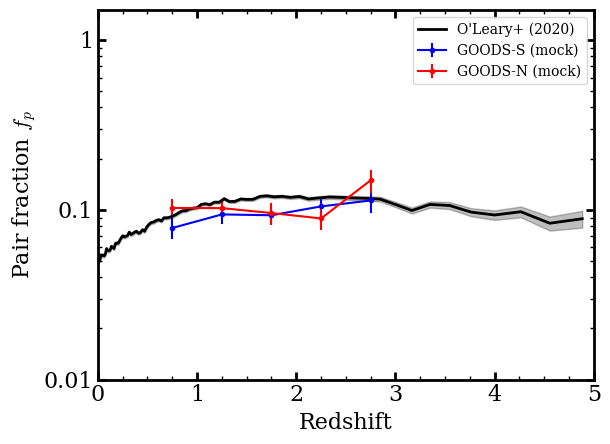

In [61]:
min_mstar, max_mstar = 10.3, np.inf
r_min, r_max = 0.005, 0.05
min_MR, max_MR = 1, 4
dv_max = 500

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xlim(0,5)
ax.set_ylim(0.01, 1.5)
ax.set_ylabel('Pair fraction $f_{p}$', size=16)
ax.set_xlabel('Redshift', size=16)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.25, 4.5+75, 0.25)))

color = ['b','r']

pairs = pd.read_hdf('./pair_counts.h5', key='P4')

z=pairs['redshift']
Np = (pairs['rp:50']-pairs['rp:5'])
Ng = pairs['N_gal']
fp = Np/Ng
err = fp/np.sqrt(Np)
ax.plot(z, fp,color='k', lw=2,label='O\'Leary+ (2020)')
ax.fill_between(z,fp+err,fp-err,alpha=0.25, color='k')

for i, obs in enumerate(observations):
    group, name = obs
    observation = P200.galaxy.survey.obs(group=group, name=name)
    bins = observation.redshift_bins
    z = (bins[:-1] + bins[1:])/2
    
    
    pairs = observation.pairs
    Np = np.zeros(len(pairs))
    Ng = np.zeros(len(pairs))
    for j in range(len(Np)):
        mstar = observation.list(index = pairs[j]['cone_id_main'].values)['Stellar_mass'].values
        mstar_mask = (mstar >= min_mstar) & (mstar < max_mstar)

        redshift = observation.list(index = pairs[j]['cone_id_main'].values)['Redshift'].values 
        dz_mask = (pairs[j]['dz'] <= dv_max*(1+redshift)/apconst.c.to('km/s').value)
        
        radius_mask = (pairs[j]['radius'] >= r_min) & (pairs[j]['radius'] < r_max)
        MR_mask = (pairs[j]['MR'] >= 1) & (pairs[j]['MR'] < 4)
        Np[j] = (mstar_mask & dz_mask & radius_mask & MR_mask).sum()
        Ng[j] = len(observation.list(slice=[j], min_mstar=min_mstar, max_mstar=max_mstar)) 

    fp = Np/Ng
    err = fp/np.sqrt(Np)
    ax.errorbar(z, fp, yerr=err, marker='.', color=color[i],label=group+' (mock)')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

plt.legend()
plt.show()

In [35]:
P200.galaxy.survey.obs(group=group, name=name).pairs[0]['dok']

array([[ 750,    0],
       [   2,    3],
       [ 868,    6],
       ...,
       [ 353, 2263],
       [ 354, 2263],
       [1683, 2266]], dtype=int32)

In [44]:
observation.distmat[0][(750, 0)]

0.07824217426855025

In [37]:
distance = self.distmat[i][(750, 0)]

NameError: name 'self' is not defined

In [47]:
P200.galaxy.survey.obs(group=group, name=name).pairs[0]['cone_id']

array([[ 750,    0],
       [   2,    3],
       [ 868,    6],
       ...,
       [ 353, 2312],
       [ 354, 2312],
       [1683, 2358]])

In [53]:
pairs = observation.pairs
a,b = observation.list(index = pairs[0]['cone_id'][:,0])[['Stellar_mass', 'Redshift']].values

ValueError: too many values to unpack (expected 2)

In [63]:
pairs

[{'MR': array([1.5895386, 2.405686 , 1.994628 , ..., 6.069002 , 1.4504406,
         1.3426301], dtype=float32),
  'dok': array([[ 750,    0],
         [   2,    3],
         [ 868,    6],
         ...,
         [ 353, 2263],
         [ 354, 2263],
         [1683, 2266]], dtype=int32),
  'dz': array([0.25885121, 0.00071646, 0.28470959, ..., 0.39076848, 0.39080375,
         0.10818118]),
  'cone_id': array([[ 750,    0],
         [   2,    3],
         [ 868,    6],
         ...,
         [ 353, 2312],
         [ 354, 2312],
         [1683, 2358]]),
  'tree_id': array([[10056861, 10266125],
         [ 7732850,  7733186],
         [11998855,  7855202],
         ...,
         [ 3781744,  6561247],
         [ 3804534,  6561247],
         [ 6722725,  6826083]]),
  'radius': array([0.07824217, 0.02919663, 0.09887754, ..., 0.05904659, 0.06252714,
         0.09998289]),
  'tdf': array([ 0.       , 10.3061409,  0.       , ...,  0.       ,  0.       ,
          0.       ])},
 {'MR': array([7.9867

In [64]:
pairs[0]

{'MR': array([1.5895386, 2.405686 , 1.994628 , ..., 6.069002 , 1.4504406,
        1.3426301], dtype=float32),
 'dok': array([[ 750,    0],
        [   2,    3],
        [ 868,    6],
        ...,
        [ 353, 2263],
        [ 354, 2263],
        [1683, 2266]], dtype=int32),
 'dz': array([0.25885121, 0.00071646, 0.28470959, ..., 0.39076848, 0.39080375,
        0.10818118]),
 'cone_id': array([[ 750,    0],
        [   2,    3],
        [ 868,    6],
        ...,
        [ 353, 2312],
        [ 354, 2312],
        [1683, 2358]]),
 'tree_id': array([[10056861, 10266125],
        [ 7732850,  7733186],
        [11998855,  7855202],
        ...,
        [ 3781744,  6561247],
        [ 3804534,  6561247],
        [ 6722725,  6826083]]),
 'radius': array([0.07824217, 0.02919663, 0.09887754, ..., 0.05904659, 0.06252714,
        0.09998289]),
 'tdf': array([ 0.       , 10.3061409,  0.       , ...,  0.       ,  0.       ,
         0.       ])}

In [71]:
min_mstar, max_mstar = 10, np.inf
r_min, r_max = 0.005, 0.1
min_MR, max_MR = 1, 10
dv_max = 1000
j=0
mstar = observation.list(index = pairs[j]['cone_id'][:,0])['Stellar_mass'].values
mstar_mask = (mstar >= min_mstar) & (mstar < max_mstar)

redshift = observation.list(index = pairs[j]['cone_id'][:,0])['Redshift'].values
dz_mask = (pairs[j]['dz'] <= dv_max*(1+redshift)/apconst.c.to('km/s').value)

radius_mask = (pairs[j]['radius'] >= r_min) & (pairs[j]['radius'] < r_max)
MR_mask = (pairs[j]['MR'] >= min_MR) & (pairs[j]['MR'] < max_MR)

#merged_mask = pairs[j]['tdf'] > 0

data_mask = (mstar_mask & dz_mask & radius_mask & MR_mask)

mstar = mstar[data_mask]
MR = pairs[j]['MR'][data_mask]
redshift = redshift[data_mask]
radius = pairs[j]['radius'][data_mask]
dz = pairs[j]['dz'][data_mask]
data = np.array([mstar, MR, redshift, radius, dz]).T

df = pd.DataFrame(data, columns=['mass', 'mu', 'z', 'rproj', 'dz'])

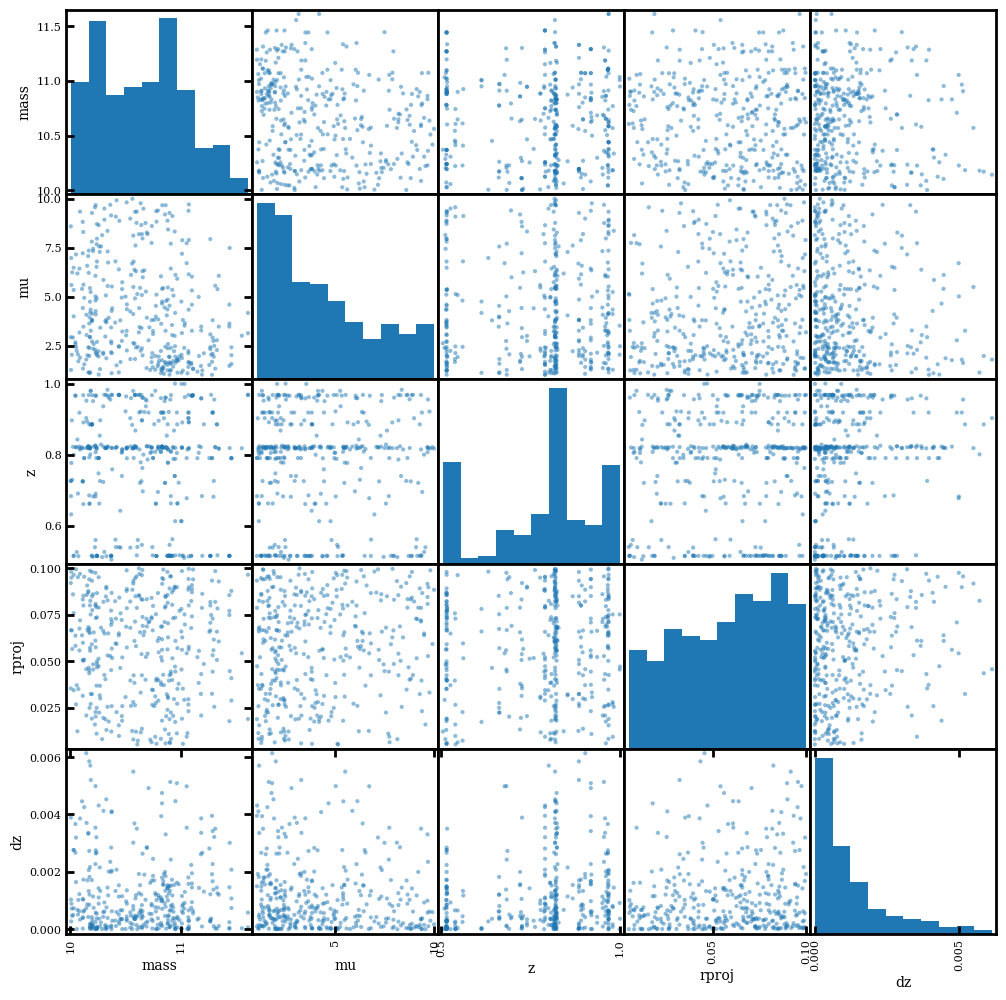

In [78]:
from pandas.plotting import scatter_matrix


scatter_matrix(df, figsize=(12, 12), diagonal='hist')
plt.show()

In [5]:
P200.galaxy.survey.new_observation(group='test', name='wide', m=8, n=5, min_z=0.5, max_z=3, min_mstar=9, fuzzy_bounds=True, randomize=True, seed=42)

In [6]:
P200.galaxy.survey.obs(group='test', name='wide').list()

Tree_ID  Redshift  Redshift_obs    X_cone     Y_cone       Z_cone  \
0        290505  0.501077      0.501848 -2.259504   2.333038  1947.860417   
1        443803  0.500724      0.501413 -1.096986   4.086487  1946.676989   
2        493655  0.501645      0.502469  2.630345  -4.396864  1949.769001   
3        539681  0.501642      0.502363 -2.677372   1.499242  1949.759750   
4       5494156  0.523939      0.524555 -2.155979  -2.840704  2024.100345   
...         ...       ...           ...       ...        ...          ...   
12624  14483141  2.974317      2.974144  0.970661 -15.676650  6484.812921   
12625  14494003  2.971342      2.968895 -4.632877 -13.953996  6481.872402   
12626  14524969  2.970165      2.970543 -1.668102 -15.951615  6480.708577   
12627  14527457  2.970520      2.971406 -5.408743 -13.574998  6481.059597   
12628   2576063  2.997686      2.999172 -9.484276  11.772533  6507.801861   

           X_cvel      Y_cvel      Z_cvel        RA  ...      X_pos  \
0     -138.985879  -20.527846  154.140245 -0.001160  ...  12.225040   
1     -135.759738   -2.838852  137.653079 -0.000564  ...  10.274768   
2      -77.088829  -92.119141  164.559375  0.001349  ...  19.197729   
3     -152.914989  -31.710229  143.770978 -0.001373  ...  13.412609   
4      105.920703  373.543529  121.021637 -0.001065  ...  67.314941   
...           ...         ...         ...       ...  ...        ...   
12624 -194.810195  -39.999281  -13.069670  0.000150  ...  92.133888   
12625   63.766258  -97.849570 -184.721700 -0.000715  ...  94.395988   
12626  138.034534  -73.857830   28.537053 -0.000257  ...  92.663132   
12627  401.402462 -155.524516   66.888828 -0.000835  ...  94.925957   
12628 -138.218109  -73.405660  111.469214 -0.001457  ...  23.296740   

           Y_pos      Z_pos       X_vel       Y_vel       Z_vel       tdf  \
0      33.035908  10.796329   50.139999 -128.820007 -156.169998  8.664212   
1      33.704853  12.051511   29.580000 -116.589996 -151.389999  8.664212   
2      31.871700  15.578705  122.389999 -132.809998  -94.290001  8.664212   
3      31.400177  10.170742   59.090000 -114.839996 -168.460007  8.664212   
4      49.709499  63.713257 -203.080002  342.839996   81.360001  8.499805   
...          ...        ...         ...         ...         ...       ...   
12624  78.133713  58.732796  -36.689999 -190.750000   44.610001  2.152648   
12625  72.889603  61.957085  -60.020000   88.110001  190.779999  2.152648   
12626  76.021309  63.107948  -78.000000  135.279999  -30.629999  2.152648   
12627  72.209465  62.771214 -165.570007  393.920013  -84.849998  2.152648   
12628  18.120705  63.669724  -77.169998 -148.940002   93.699997  2.152648   

            Age  Type  Flag  
0      8.664212     0     0  
1      8.664212     0     0  
2      8.664212     0     0  
3      8.664212     0     0  
4      8.499805     0     0  
...         ...   ...   ...  
12624  2.152648     0     0  
12625  2.152648     0     0  
12626  2.152648     1     0  
12627  2.152648     0     0  
12628  2.152648     0     0  

[12629 rows x 44 columns]

In [7]:
P200.galaxy.survey.obs(group='GOODS-S', name='wide').list()

Tree_ID  Redshift  Redshift_obs    X_cone     Y_cone       Z_cone  \
0        290505  0.501077      0.501848 -2.259504   2.333038  1947.860417   
1        443803  0.500724      0.501413 -1.096986   4.086487  1946.676989   
2        493655  0.501645      0.502469  2.630345  -4.396864  1949.769001   
3        539681  0.501642      0.502363 -2.677372   1.499242  1949.759750   
4      10227840  0.525406      0.525445  3.127176  -2.810138  2028.954363   
...         ...       ...           ...       ...        ...          ...   
12624  14483141  2.974317      2.974144  0.970661 -15.676650  6484.812921   
12625  14494003  2.971342      2.968895 -4.632877 -13.953996  6481.872402   
12626  14524969  2.970165      2.970543 -1.668102 -15.951615  6480.708577   
12627  14527457  2.970520      2.971406 -5.408743 -13.574998  6481.059597   
12628   2576063  2.997686      2.999172 -9.484276  11.772533  6507.801861   

           X_cvel      Y_cvel      Z_cvel        RA  ...      X_pos  \
0     -138.985879  -20.527846  154.140245 -0.001160  ...  12.225040   
1     -135.759738   -2.838852  137.653079 -0.000564  ...  10.274768   
2      -77.088829  -92.119141  164.559375  0.001349  ...  19.197729   
3     -152.914989  -31.710229  143.770978 -0.001373  ...  13.412609   
4     -330.417373   45.640556    7.744279  0.001541  ...  61.929344   
...           ...         ...         ...       ...  ...        ...   
12624 -194.810195  -39.999281  -13.069670  0.000150  ...  92.133888   
12625   63.766258  -97.849570 -184.721700 -0.000715  ...  94.395988   
12626  138.034534  -73.857830   28.537053 -0.000257  ...  92.663132   
12627  401.402462 -155.524516   66.888828 -0.000835  ...  94.925957   
12628 -138.218109  -73.405660  111.469214 -0.001457  ...  23.296740   

           Y_pos      Z_pos       X_vel       Y_vel       Z_vel       tdf  \
0      33.035908  10.796329   50.139999 -128.820007 -156.169998  8.664212   
1      33.704853  12.051511   29.580000 -116.589996 -151.389999  8.664212   
2      31.871700  15.578705  122.389999 -132.809998  -94.290001  8.664212   
3      31.400177  10.170742   59.090000 -114.839996 -168.460007  8.664212   
4      48.794601  68.364326   24.629999   43.259998 -329.910004  8.499805   
...          ...        ...         ...         ...         ...       ...   
12624  78.133713  58.732796  -36.689999 -190.750000   44.610001  2.152648   
12625  72.889603  61.957085  -60.020000   88.110001  190.779999  2.152648   
12626  76.021309  63.107948  -78.000000  135.279999  -30.629999  2.152648   
12627  72.209465  62.771214 -165.570007  393.920013  -84.849998  2.152648   
12628  18.120705  63.669724  -77.169998 -148.940002   93.699997  2.152648   

            Age  Type  Flag  
0      8.664212     0     0  
1      8.664212     0     0  
2      8.664212     0     0  
3      8.664212     0     0  
4      8.499805     0     0  
...         ...   ...   ...  
12624  2.152648     0     0  
12625  2.152648     0     0  
12626  2.152648     1     0  
12627  2.152648     0     0  
12628  2.152648     0     0  

[12629 rows x 44 columns]

In [16]:
pairs = observation.pairs

In [15]:
observation.distmat[0][(2,3)]

0.029196629889935485

In [18]:
i = 0
for j in range(len(pairs[i]['dok_main'])):
    dok_1 = pairs[i].iloc[j]['dok_main']
    dok_2 = pairs[i].iloc[j]['dok_minor']
    observation.pairs[i].iloc[j]['radius'] = observation.distmat[i][(dok_1, dok_2)]

In [36]:
(observation.pairs[1].tdf>0).sum()

324

In [38]:
df = pd.concat(observation.pairs)

In [39]:
from pandas.plotting import scatter_matrix

slice  dok_main  dok_minor  cone_id_main  cone_id_minor  tree_id_main  \
0         0       750          0           750              0      10056861   
1         0         2          3             2              3       7732850   
2         0       868          6           868              6      11998855   
3         0      2028          6          2028              6       6545037   
4         0      2061          9          2061              9      13181529   
...     ...       ...        ...           ...            ...           ...   
1127      4       246       1625         11175          12554       9920614   
1128      4       530       1625         11459          12554      11468268   
1129      4      1617       1626         12546          12555      14478551   
1130      4      1618       1626         12547          12555      14478574   
1131      4      1535       1627         12464          12556      13246829   

      tree_id_minor    radius        dz        MR        tdf  
0          10266125  0.078242  0.258851  1.589539   0.000000  
1           7733186  0.029197  0.000716  2.405686  10.306141  
2           7855202  0.098878  0.284710  1.994628   0.000000  
3           7855202  0.075764  0.454335  1.410763   0.000000  
4           7895857  0.032099  0.466848  4.994950   0.000000  
...             ...       ...       ...       ...        ...  
1127       14518059  0.013540  0.434316  7.804900   0.000000  
1128       14518059  0.020899  0.279377  1.444722   0.000000  
1129       14519952  0.007514  0.002587  1.449966   0.000000  
1130       14519952  0.015901  0.003510  7.183476   0.000000  
1131       14526455  0.075799  0.006739  1.750804   0.000000  

[11517 rows x 11 columns]

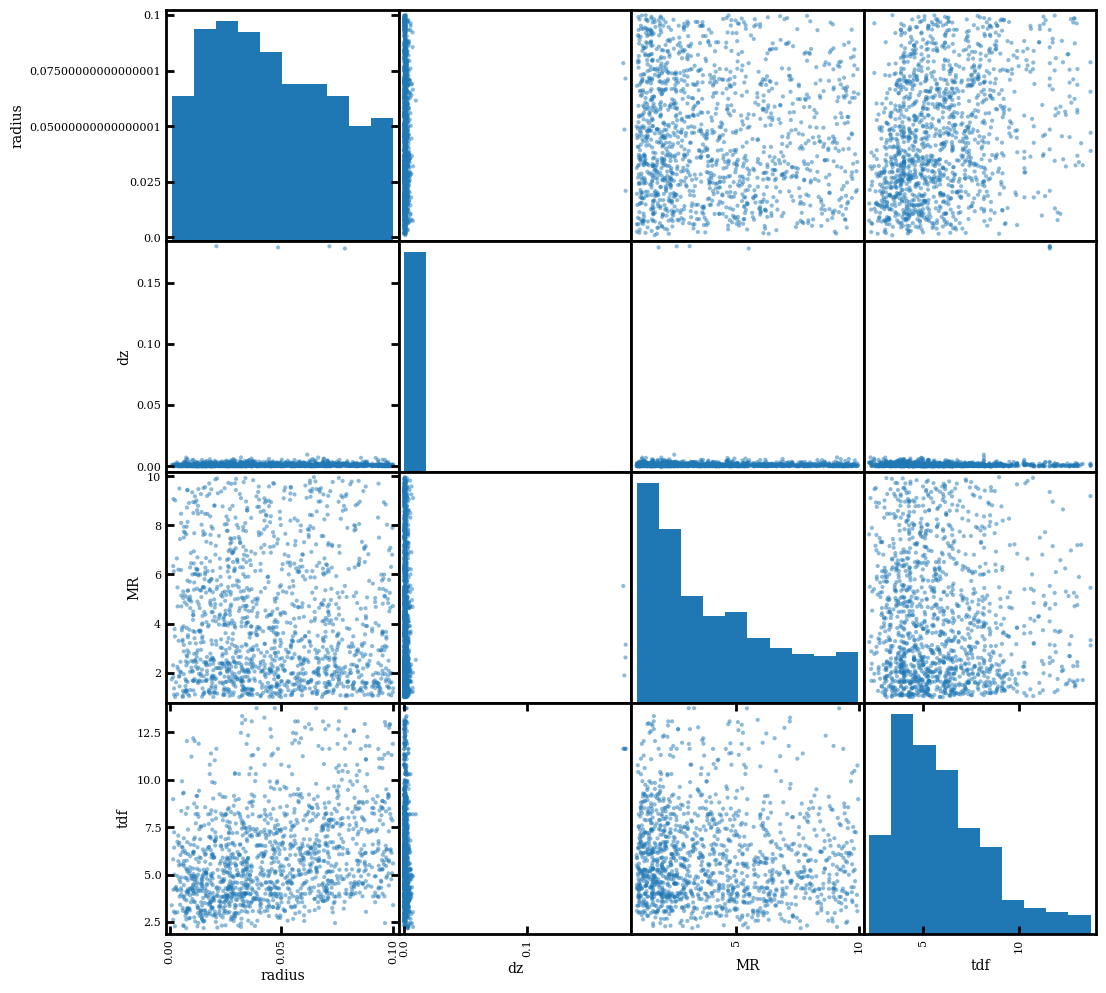

In [42]:
scatter_matrix(df.loc[df.tdf>0][['radius', 'dz', 'MR', 'tdf']], figsize=(12, 12), diagonal='hist')
plt.show()

In [52]:
min_mstar, max_mstar = 10.0, np.inf
r_min, r_max = 0.005, 0.05
min_MR, max_MR = 1, 1
dv_max = 500
tdf_mask = (df.tdf > 0).values


t_merge = df.tdf.values - observation.list(index = df['cone_id_main'].values)['Age'].values
mstar = observation.list(index = df['cone_id_main'].values)['Stellar_mass'].values
mstar_mask = (mstar >= min_mstar) & (mstar < max_mstar)



In [53]:
t_merge[tdf_mask & mstar_mask]

array([1.80633545e+00, 5.57231903e-02, 9.54940796e-01, 4.06068516e+00,
       3.12949371e+00, 3.12949371e+00, 7.80857086e-01, 1.42270660e+00,
       1.50729275e+00, 3.40204048e+00, 1.23035431e-01, 1.90563202e-02,
       1.80238724e-01, 9.87548828e-01, 4.74922180e+00, 2.72731781e-02,
       2.20177650e-01, 4.70613861e+00, 2.88464737e+00, 3.84187698e-02,
       3.07221127e+00, 5.06399393e+00, 7.94357777e-01, 5.60034752e-01,
       1.72730446e+00, 1.72730446e+00, 7.92774200e-01, 1.58087730e+00,
       1.41116381e+00, 6.36150837e-01, 3.68393946e+00, 1.53675985e+00,
       3.42438650e+00, 1.11651659e+00, 6.14643097e-01, 2.04259300e+00,
       1.94836044e+00, 2.14262962e-01, 6.58491325e+00, 6.58491325e+00,
       1.83422184e+00, 5.26047134e+00, 1.43526840e+00, 9.66103554e-01,
       1.09442997e+00, 3.56600285e-01, 2.13183689e+00, 2.13183689e+00,
       8.57956886e-01, 4.23675346e+00, 1.24234200e+00, 5.04020405e+00,
       5.47488022e+00, 6.50746441e+00, 2.51462460e-01, 1.03966093e+00,
      

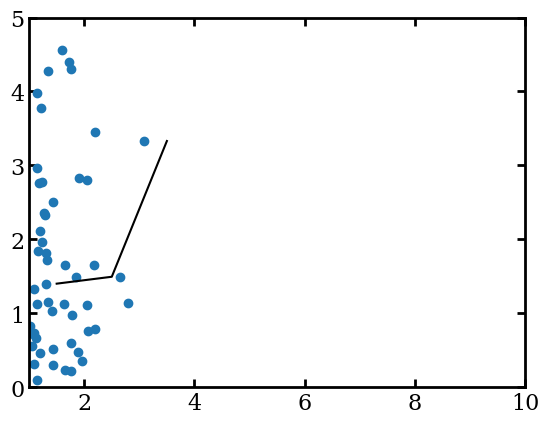

In [92]:
min_mstar, max_mstar = 9, 9.5
r_min, r_max = 0.005, 0.05
min_MR, max_MR = 1, 10
dv_max = 500
tdf_mask = (df.tdf > 0).values


t_merge = df.tdf.values - observation.list(index = df['cone_id_main'].values)['Age'].values
mstar = observation.list(index = df['cone_id_main'].values)['Stellar_mass'].values
mstar_mask = (mstar >= min_mstar) & (mstar < max_mstar)

radius_mask = (df['radius'] >= r_min) & (df['radius'] < r_max)


fig, ax = plt.subplots()
ax.set_ylim(0,5)
ax.set_xlim(1,10)
x = df.loc[tdf_mask & mstar_mask & radius_mask]['MR'].values
y = t_merge[tdf_mask & mstar_mask & radius_mask]
ax.plot(x,y,'o')
t, edges, binnumber = binned_statistic(x, y,statistic='median',bins=np.arange(11))
b = (edges[1:] + edges[:-1]) / 2
ax.plot(b,t,'k-')
plt.show()

In [ ]:
b = (edges[1:] + edges[:-1]) / 2

In [87]:
observation.list(index = df['cone_id_minor'].values)['Stellar_mass'].min()

9.000127

In [5]:
P200.galaxy.survey.avail()

Loaded:
    Snyder16
        wide-A
        wide-B
        wide-C
        thin-A
        thin-B
        thin-C
    GOODS-S
        wide
    GOODS-N
        wide
In file:
    GOODS-N
        wide
    GOODS-S
        wide
    Snyder16
        thin-A
        thin-B
        thin-C
        wide-A
        wide-B
        wide-C


In [19]:
scalefactor_bins, redshift_bins, time_bins = gb.make_time_bins(P200.cosmology, db=1, db_type='dt',max_redshift=4)

Making bins evenly spaced in time


In [31]:
from galaxybox_dev.mock_observables import lightcone
from astropy.coordinates import Angle

In [60]:
RA, Dec = '42.30839 deg', '42.30839 deg'

if isinstance(RA, (float, int, str)):
    RA = Angle(RA, apunits.radian)
if isinstance(Dec, (float, int, str)):
    Dec = Angle(Dec, apunits.radian)

n = (RA.value / (Dec.value**2))**(1 / 3)
m = n * Dec.value / RA.value
print(m, n)

1.1063657203488453 1.1063657203488453


In [62]:
LC = lightcone.KW07(m=1.10636, n=1.10636,Lbox=100)

In [63]:
LC.da.to('deg')**2

<Quantity 1790.05539545 deg2>

In [65]:
P200.galaxy.survey.avail()

Loaded:
    Snyder16
        wide-A
        wide-B
        wide-C
        thin-A
        thin-B
        thin-C
    GOODS-S
        wide
        deep
    GOODS-N
        wide
        deep
    COSMOS
        wide
    UDS
        wide
    EGS
        wide
    SDSS
        DR4
In file:
    COSMOS
        wide
    EGS
        wide
    GOODS-N
        deep
        wide
    GOODS-S
        deep
        wide
    SDSS
        DR4
    Snyder16
        thin-A
        thin-B
        thin-C
        wide-A
        wide-B
        wide-C
    UDS
        wide


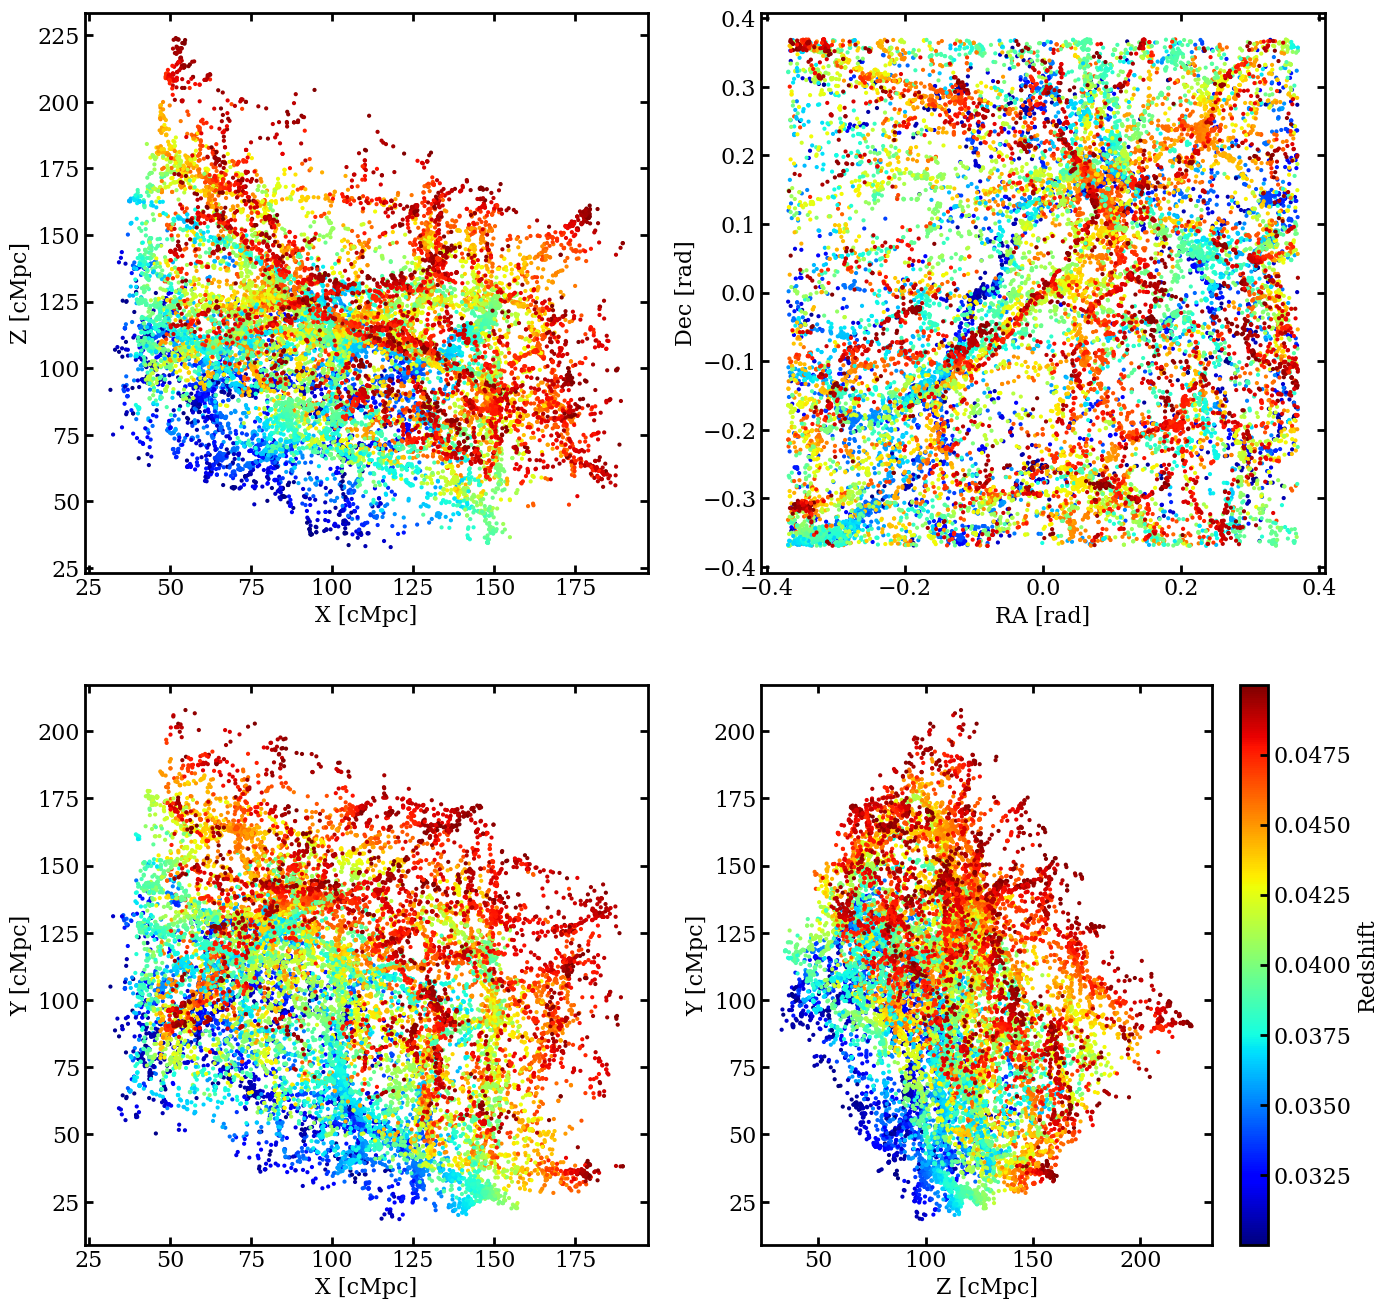

In [7]:
P200.galaxy.survey.obs(group='SDSS', name='DR4').plot_cone(frame='box')
plt.show()

In [72]:
P200.galaxy.survey.obs(group='SDSS', name='DR4').list(min_mstar=9.7)

Tree_ID  Redshift  Redshift_obs     X_cone     Y_cone      Z_cone  \
1        102570  0.031058      0.030744  19.214008  22.707691  136.316264   
2        112553  0.031052      0.032923  18.891169  22.709948  136.293866   
3        114503  0.031056      0.032927  19.091628  22.576529  136.309351   
4        130563  0.032622      0.034275  15.483938  21.950026  143.129557   
7        132391  0.032623      0.034276  15.423307  21.959146  143.132683   
...         ...       ...           ...        ...        ...         ...   
23975  13916141  0.047523      0.047661  45.608513  15.194761  207.775210   
23976  13918935  0.047927      0.048504  45.779883  14.223273  209.522250   
23978  13989311  0.047509      0.046658  -8.403108 -22.466581  207.712745   
23985  14119274  0.047922      0.048307  45.589286  14.251073  209.499763   
23986  14293472  0.047934      0.046536  -7.785010 -25.288512  209.552714   

           X_cvel      Y_cvel      Z_cvel        RA  ...      X_pos  \
1      -32.720392 -153.143443  -91.025460  0.140029  ...   1.068161   
2      -30.442273   14.712605  543.910237  0.137729  ...   1.319296   
3      -30.442273   14.712605  543.910237  0.139156  ...   1.211783   
4      -73.464045  -21.012721  480.002645  0.107762  ...   0.323800   
7      -73.464045  -21.012721  480.002645  0.107341  ...   0.363634   
...           ...         ...         ...       ...  ...        ...   
23975 -326.725648    1.550570   39.444557  0.216082  ...  54.411060   
23976 -347.059343  224.144632  164.860158  0.215116  ...  56.190918   
23978   12.845401 -331.351441 -243.364974 -0.040433  ...  85.656265   
23985 -229.526599  183.892690  110.056741  0.214270  ...  56.155304   
23986  -95.603600 -261.206756 -400.046627 -0.037134  ...  89.024780   

           Y_pos      Z_pos       X_vel       Y_vel       Z_vel        tdf  \
1       9.174311  13.962130  132.160004  -76.500000   97.419998  13.363264   
2       9.188659  13.758519 -285.829987 -290.700012 -361.630005  40.264187   
3       9.069222  13.938519 -285.829987 -290.700012 -361.630005  13.363264   
4       4.750500   7.575873 -204.979996 -284.779999 -336.339996  14.199930   
7       4.756334   7.529524 -204.979996 -284.779999 -336.339996  13.363264   
...          ...        ...         ...         ...         ...        ...   
23975  71.213997  96.192535   20.680000  244.029999  219.839996  13.068719   
23976  71.774162  95.455223  -94.349998  426.910004   81.949997  13.068719   
23978  91.832413  50.361290  139.669998 -295.470001  249.750000  13.068719   
23985  71.899597  95.598763  -91.440002  297.700012   40.310001  13.068719   
23986  91.385742  49.931854   -5.850000 -290.309998  391.269989  13.475696   

             Age  Type  Flag  
1      13.363264     0     0  
2      13.363264     2     0  
3      13.363264     1     0  
4      13.363264     2     0  
7      13.363264     0     0  
...          ...   ...   ...  
23975  13.068719     1     0  
23976  13.068719     1     0  
23978  13.068719     1     0  
23985  13.068719     1     0  
23986  13.068719     2     2  

[13304 rows x 44 columns]

In [75]:
P200.galaxy.survey.obs(group='SDSS', name='DR4').geometry.da.to('deg')*P200.galaxy.survey.obs(group='SDSS', name='DR4').geometry.dd.to('deg')

<Quantity 1790.05539545 deg2>

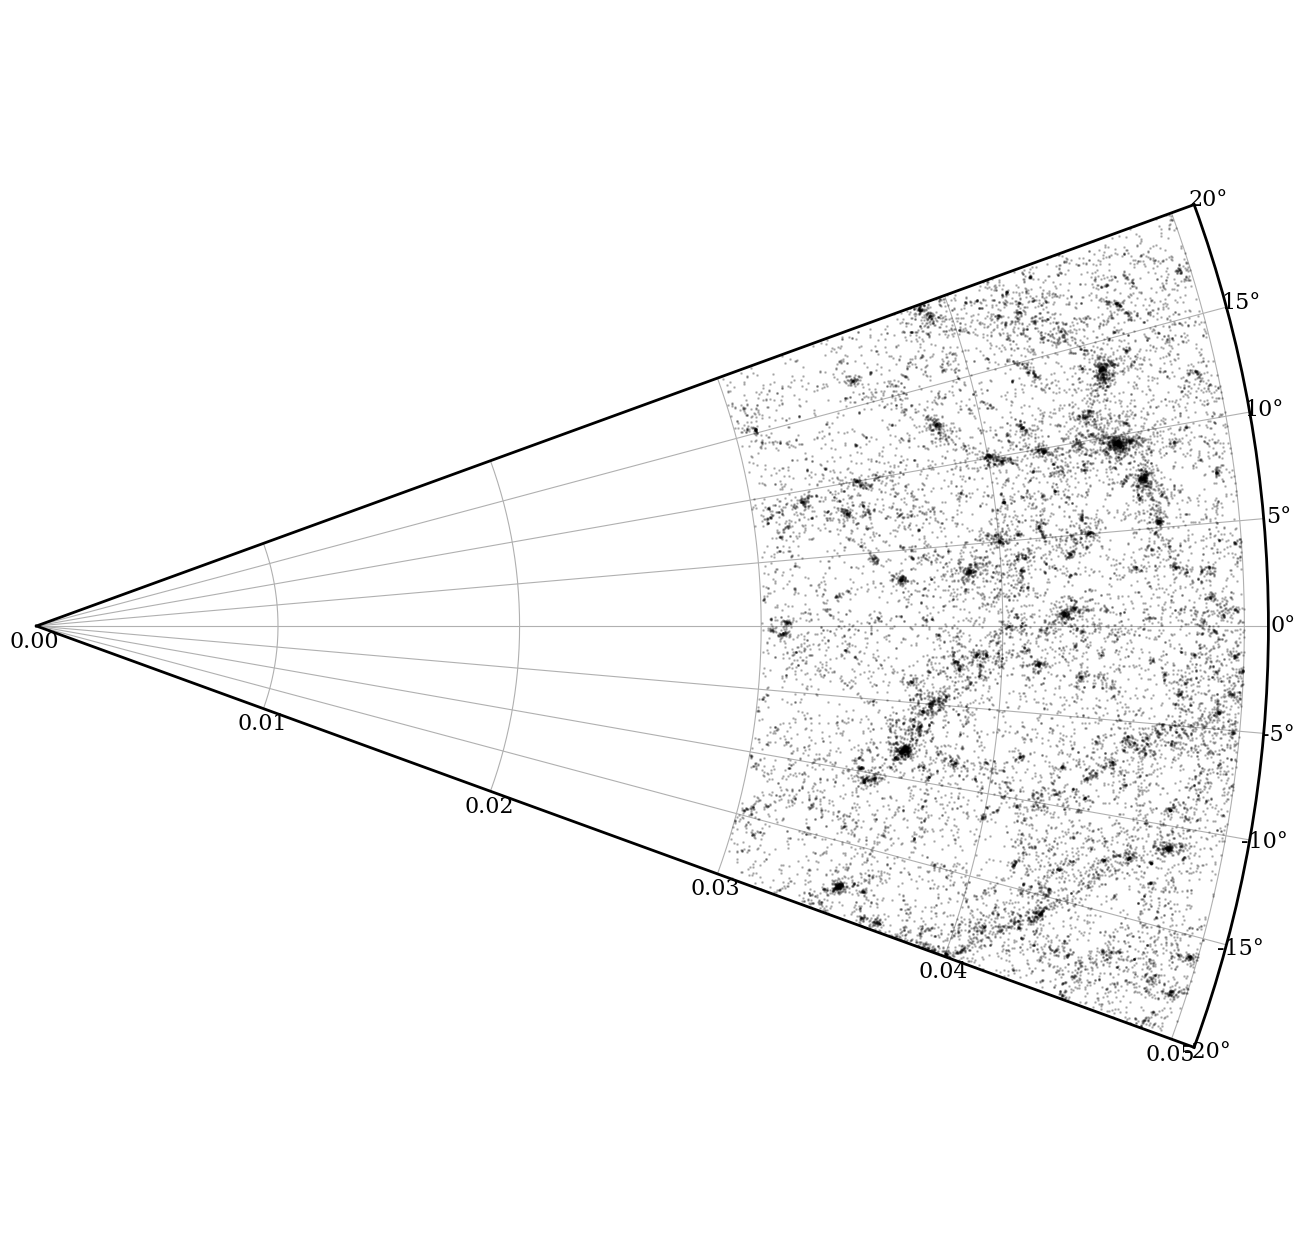

In [6]:
LC_cat = P200.galaxy.survey.obs(group='SDSS', name='DR4').list()
shift = 0
ms=2
fig, ax = plt.subplots(figsize=(16,16), subplot_kw=dict(polar=True))
ax.plot(LC_cat['Dec']+shift, LC_cat['Redshift'], 'k.', alpha=0.2, markersize=ms)

frac=0.1
tmin = (shift+LC_cat['Dec'].min())*180/np.pi + (shift+LC_cat['Dec'].min())*180/np.pi
tmax = (shift+LC_cat['Dec'].max())*180/np.pi + (shift+LC_cat['Dec'].max())*180/np.pi
ax.set_thetamin(-20)
ax.set_thetamax(20)
plt.show()

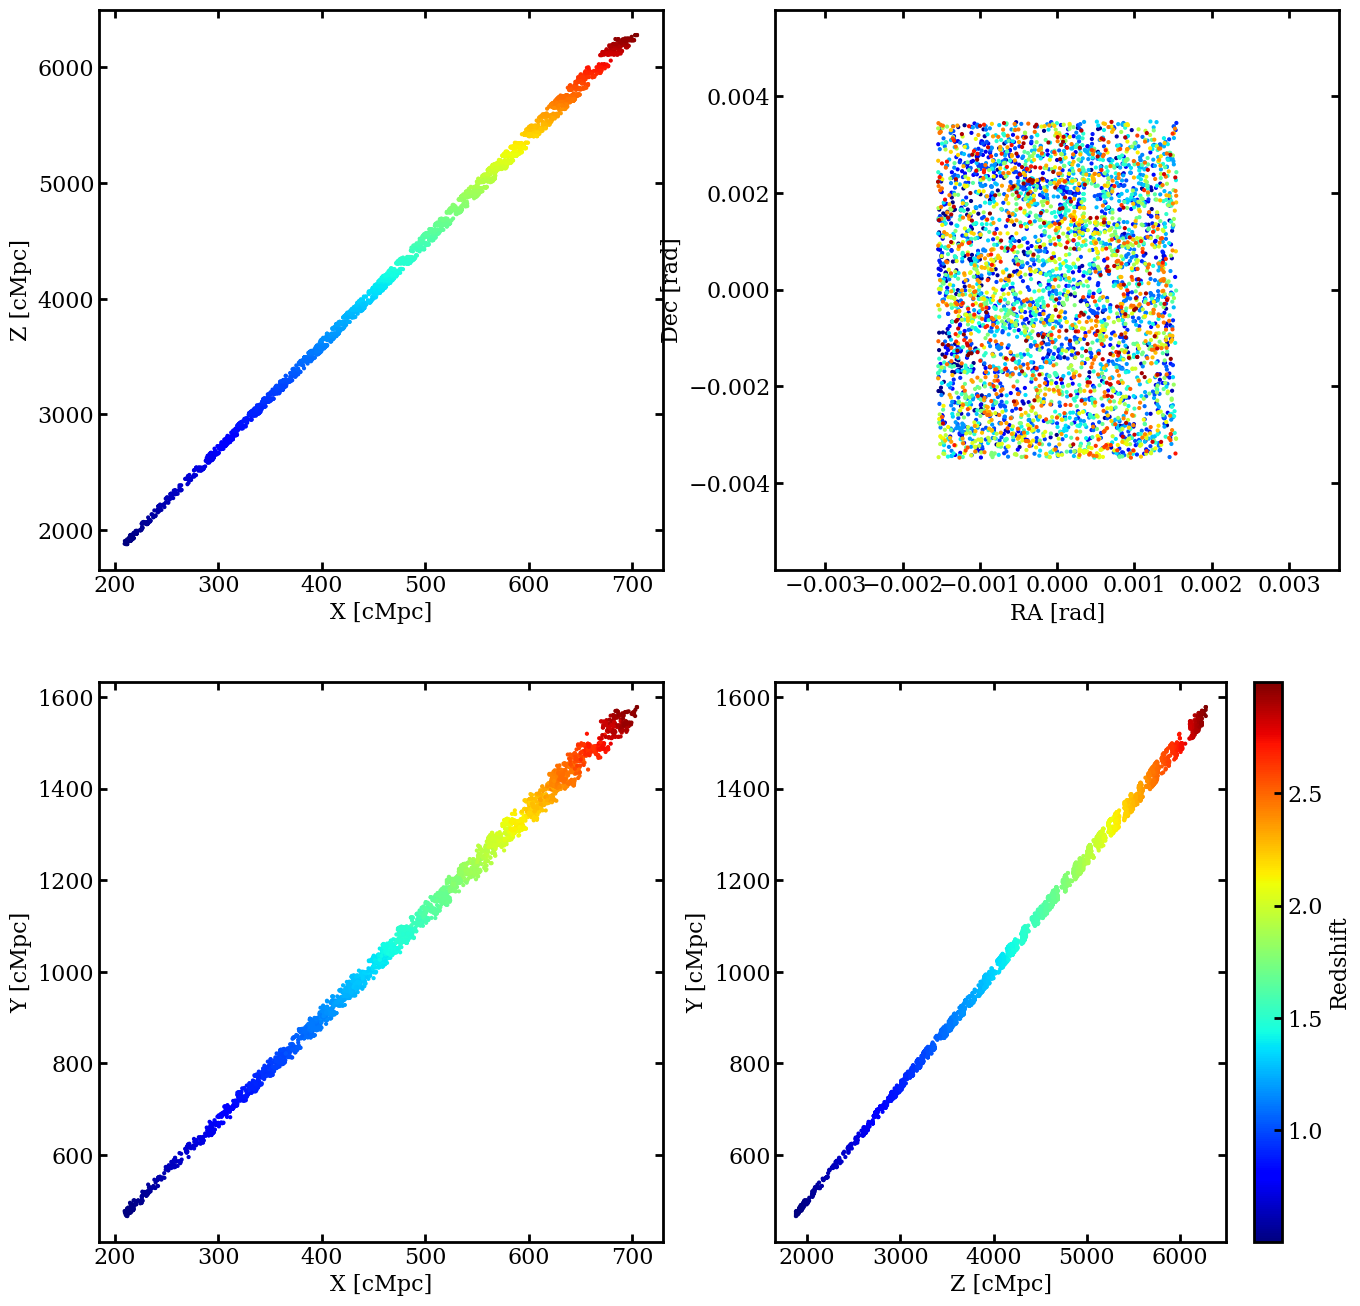

In [93]:
P200.galaxy.survey.obs(group='UDS', name='wide').plot_cone(frame='box', min_mstar=10.3)
plt.show()

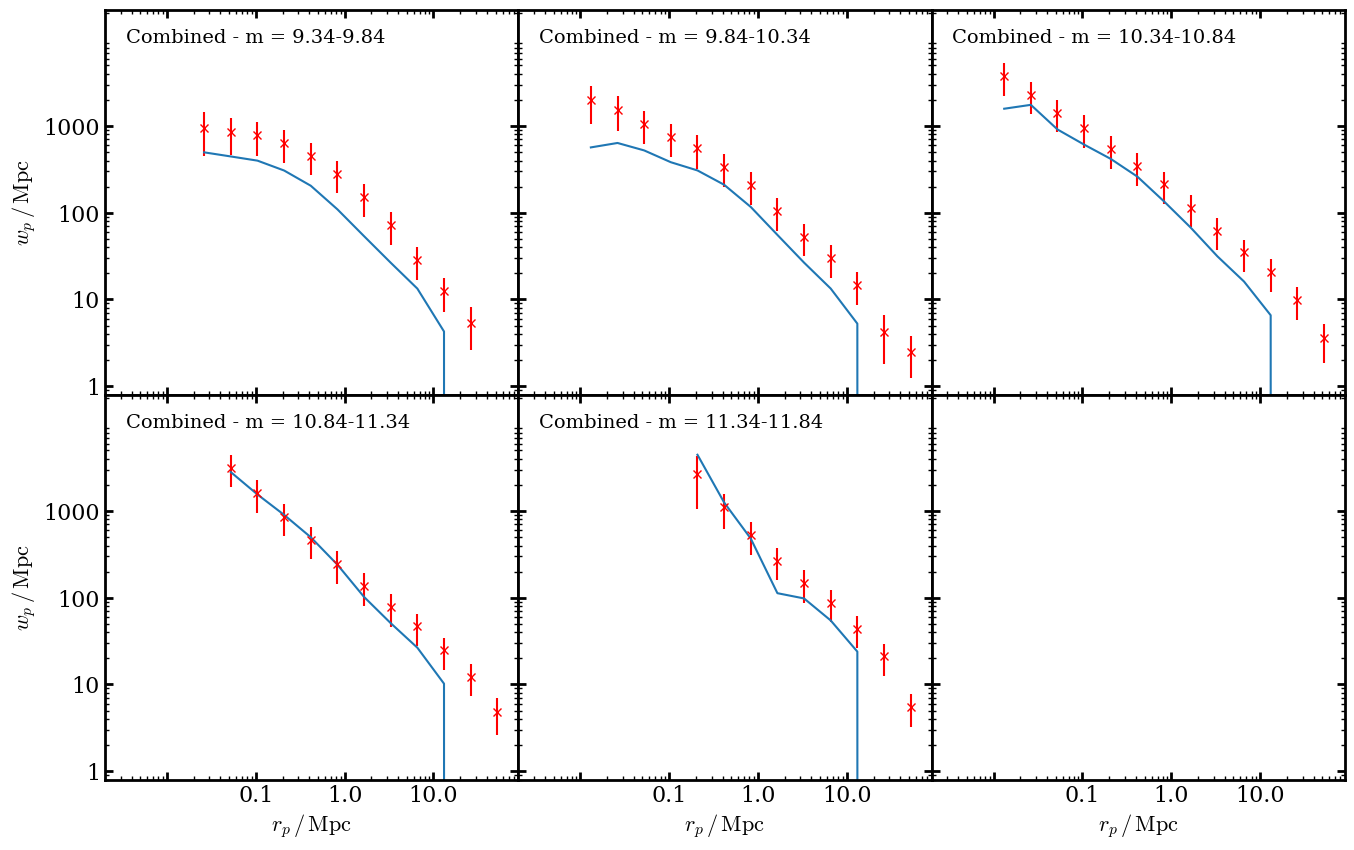

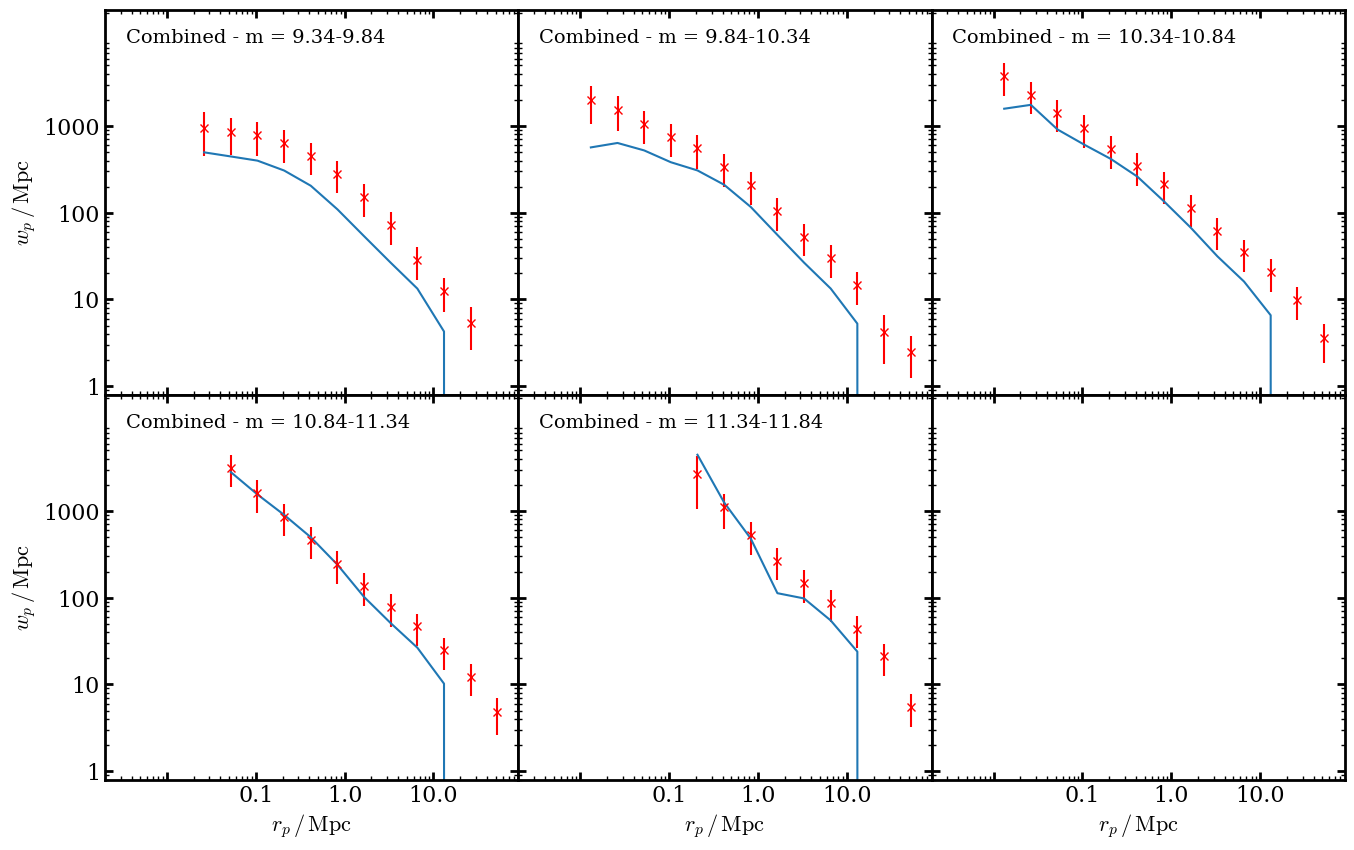

In [101]:
P200.statistics.plot('clustering')
plt.show()

In [110]:
pair_path = os.path.join(P200.out_dir,'lightcone_pairs.h5')
for i, obs in enumerate(observations):
    group, name, redshift_bins = obs
    observation = P200.galaxy.survey.obs(group=group, name=name)
    pd.concat(observation.pairs).to_hdf(pair_path, key=group+'/'+name, data_columns=True)

In [111]:
pd.read_hdf(pair_path, key='GOODS-S/wide')

slice  dok_main  dok_minor  cone_id_main  cone_id_minor  tree_id_main  \
0         0      1407          1          1407              1       6662626   
1         0       290          2           290              2      12015732   
2         0       835          2           835              2      10206647   
3         0       364          6           364              6      13851507   
4         0         8          9             8              9       6360517   
...     ...       ...        ...           ...            ...           ...   
1626      4      1920       1941         12601          12622      13392860   
1627      4      1474       1942         12155          12623      13789720   
1628      4       848       1945         11529          12626       6088063   
1629      4      1890       1945         12571          12626      13148252   
1630      4      1900       1946         12581          12627      13159271   

      tree_id_minor    radius        dz        MR       tdf  
0            443803  0.059903  0.340199  2.349108  0.000000  
1            493655  0.039924  0.083709  2.072916  0.000000  
2            493655  0.086006  0.222761  4.072628  0.000000  
3          10247015  0.012624  0.077090  1.738823  0.000000  
4           6360821  0.061494  0.000387  4.395780  9.591606  
...             ...       ...       ...       ...       ...  
1626       14378208  0.089899  0.005205  5.901349  0.000000  
1627       14402954  0.075563  0.151468  2.313905  0.000000  
1628       14524969  0.066381  0.243479  2.730044  0.000000  
1629       14524969  0.006821  0.002537  1.461506  0.000000  
1630       14527457  0.081914  0.002724  3.237225  0.000000  

[11037 rows x 11 columns]

In [112]:
pd.concat(P200.galaxy.survey.obs(group='GOODS-S', name='wide').pairs)

slice  dok_main  dok_minor  cone_id_main  cone_id_minor  tree_id_main  \
0         0      1407          1          1407              1       6662626   
1         0       290          2           290              2      12015732   
2         0       835          2           835              2      10206647   
3         0       364          6           364              6      13851507   
4         0         8          9             8              9       6360517   
...     ...       ...        ...           ...            ...           ...   
1626      4      1920       1941         12601          12622      13392860   
1627      4      1474       1942         12155          12623      13789720   
1628      4       848       1945         11529          12626       6088063   
1629      4      1890       1945         12571          12626      13148252   
1630      4      1900       1946         12581          12627      13159271   

      tree_id_minor    radius        dz        MR       tdf  
0            443803  0.059903  0.340199  2.349108  0.000000  
1            493655  0.039924  0.083709  2.072916  0.000000  
2            493655  0.086006  0.222761  4.072628  0.000000  
3          10247015  0.012624  0.077090  1.738823  0.000000  
4           6360821  0.061494  0.000387  4.395780  9.591606  
...             ...       ...       ...       ...       ...  
1626       14378208  0.089899  0.005205  5.901349  0.000000  
1627       14402954  0.075563  0.151468  2.313905  0.000000  
1628       14524969  0.066381  0.243479  2.730044  0.000000  
1629       14524969  0.006821  0.002537  1.461506  0.000000  
1630       14527457  0.081914  0.002724  3.237225  0.000000  

[11037 rows x 11 columns]

In [117]:
from galaxybox_dev.io.io import recursive_hdf5

In [123]:
file = h5py.File(pair_path,'r')
pairs = recursive_hdf5(file)
file.close()

In [ ]:
for i, obs in enumerate(observations):
    group, name, redshift_bins = obs
    if i == 0:
        allpairs = P200.galaxy.survey.obs(group=group, name=name).pairs
    else:
        allpairs = pd.concat([allpairs, P200.galaxy.survey.obs(group=group, name=name).pairs])
allpairs.reset_index(drop=True, inplace=True)   

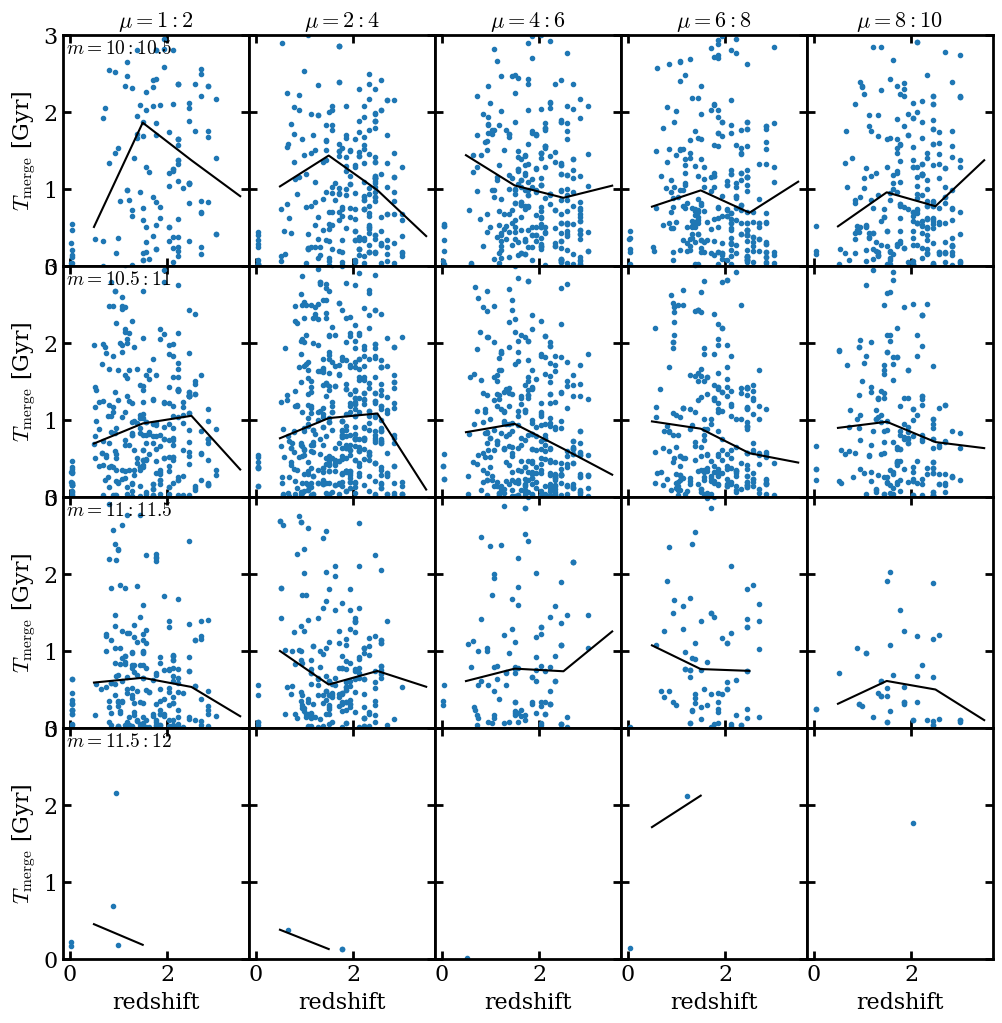

In [193]:
mass = [(10, 10.5),
        (10.5, 11),
        (11, 11.5),
        (11.5, 12)]

mu = [(1,2),
      (2,4),
      (4,6),
      (6,8),
      (8,10)]

min_mstar, max_mstar = 10.0, np.inf
r_min, r_max = 0.005, 0.05
min_MR, max_MR = 1, 1
dv_max = 500
tdf_mask = (allpairs.tdf > 0).values


fig,ax = plt.subplots(4,5,figsize=(12,12),sharex=True,sharey=True)
fig.subplots_adjust(hspace=0.0,wspace=0.0)
ax[0,0].set_ylim(0,3)

ax[0,0].set_ylabel('$T_{\mathrm{merge}}$ [Gyr]', size=16)
ax[1,0].set_ylabel('$T_{\mathrm{merge}}$ [Gyr]', size=16)
ax[2,0].set_ylabel('$T_{\mathrm{merge}}$ [Gyr]', size=16)
ax[3,0].set_ylabel('$T_{\mathrm{merge}}$ [Gyr]', size=16)

ax[-1,0].set_xlabel('redshift', size=16)
ax[-1,1].set_xlabel('redshift', size=16)
ax[-1,2].set_xlabel('redshift', size=16)
ax[-1,3].set_xlabel('redshift', size=16)
ax[-1,4].set_xlabel('redshift', size=16)

ax[0,0].set_title('$\mu=1:2$', size=16)
ax[0,1].set_title('$\mu=2:4$', size=16)
ax[0,2].set_title('$\mu=4:6$', size=16)
ax[0,3].set_title('$\mu=6:8$', size=16)
ax[0,4].set_title('$\mu=8:10$', size=16)

ax[0,0].annotate('$m=10:10.5$', xy=(0.02, 1-0.02), xycoords='axes fraction', size=14, ha='left', va='top')
ax[1,0].annotate('$m=10.5:11$', xy=(0.02, 1-0.02), xycoords='axes fraction', size=14, ha='left', va='top')
ax[2,0].annotate('$m=11:11.5$', xy=(0.02, 1-0.02), xycoords='axes fraction', size=14, ha='left', va='top')
ax[3,0].annotate('$m=11.5:12$', xy=(0.02, 1-0.02), xycoords='axes fraction', size=14, ha='left', va='top')

for i, m in enumerate(mass):
    min_mstar, max_mstar = m
    for j, mr in enumerate(mu):
        min_MR, max_MR = mr
        t_merge = allpairs.tdf.values - P200.galaxy.trees.loc[allpairs['tree_id_main'].values]['Age'].values
        redshift = 1/P200.galaxy.trees.loc[allpairs['tree_id_main'].values]['Scale'].values - 1
        mstar = P200.galaxy.trees.loc[allpairs['tree_id_main'].values]['Stellar_mass'].values
        mstar_mask = (mstar >= min_mstar) & (mstar < max_mstar)
        mu_mask = (allpairs.MR.values >= min_MR) & (allpairs.MR.values < max_MR) 
        radius_mask = (allpairs['radius'] >= r_min) & (allpairs['radius'] < r_max)
        
        x = redshift[tdf_mask & mstar_mask & radius_mask & mu_mask]
        y = t_merge[tdf_mask & mstar_mask & radius_mask & mu_mask]
        ax[i,j].plot(x,y,'.')
        t, edges, binnumber = binned_statistic(x, y,statistic='median',bins=np.arange(5))
        b = (edges[1:] + edges[:-1]) / 2
        ax[i,j].plot(b,t,'k-')

plt.show()

In [153]:
hours = float(input('enter your hours: '))
rate = float(input('enter your rate: '))
salary = rate*hours
print('your salary is ${:.2f}'.format(salary))

enter your hours: 23
enter your rate: 7.73
your salary is $177.79


In [163]:
i = float(2.73)
int(i)

2

In [168]:
for i, obs in enumerate(observations):
    group, name, redshift_bins = obs
    if i == 0:
        allpairs = P200.galaxy.survey.obs(group=group, name=name).pairs
    else:
        allpairs = pd.concat([allpairs, P200.galaxy.survey.obs(group=group, name=name).pairs])
allpairs.reset_index(drop=True, inplace=True)    

In [149]:
np.floor(1.3)

1.0

In [175]:
allpairs

slice  dok_main  dok_minor  cone_id_main  cone_id_minor  tree_id_main  \
0          0      1407          1          1407              1       6662626   
1          0       290          2           290              2      12015732   
2          0       835          2           835              2      10206647   
3          0       364          6           364              6      13851507   
4          0         8          9             8              9       6360517   
...      ...       ...        ...           ...            ...           ...   
77249      0     23967      23976         23967          23976      13691858   
77250      0     23968      23979         23968          23979      13707944   
77251      0     23966      23980         23966          23980      13685285   
77252      0     23969      23981         23969          23981      13727743   
77253      0     23961      23986         23961          23986      13568640   

       tree_id_minor    radius        dz        MR       tdf  
0             443803  0.059903  0.340199  2.349108  0.000000  
1             493655  0.039924  0.083709  2.072916  0.000000  
2             493655  0.086006  0.222761  4.072628  0.000000  
3           10247015  0.012624  0.077090  1.738823  0.000000  
4            6360821  0.061494  0.000387  4.395780  9.591606  
...              ...       ...       ...       ...       ...  
77249       13918935  0.021029  0.000199  6.254933  0.000000  
77250       13991888  0.075703  0.001981  9.998528  0.000000  
77251       14009214  0.095624  0.000125  6.563663  0.000000  
77252       14047256  0.038853  0.000396  9.165704  0.000000  
77253       14293472  0.012816  0.000006  3.234269  0.000000  

[77254 rows x 11 columns]

In [8]:
P200.galaxy.trees.loc[[1036831949]]

KeyError: "None of [Int64Index([1036831949], dtype='int64', name='ID')] are in the [index]"

In [12]:
1036831949 in P200.galaxy.survey.obs(group='GOODS-S', name='wide').list().Tree_ID.values

False

In [14]:
observation = P200.galaxy.survey.obs(group='GOODS-S', name='wide')
pairs = [None]*(len(observation.redshift_bins)-1)

In [32]:
num_procs=8
i = 0
pairs[i] = pd.DataFrame(columns=['slice', 'dok_main', 'dok_minor','cone_id_main', 'cone_id_minor', 'tree_id_main', 'tree_id_minor', 'radius', 'dz', 'MR', 'tdf'])

pair_dok = np.array(observation.distmat[i].nonzero()).T
galaxies = observation.list(slice=i)
# get the properties for each pair
G1_prop = galaxies.iloc[pair_dok[:,0]]
G2_prop = galaxies.iloc[pair_dok[:,1]]

MR = (G1_prop['Stellar_mass'].values-G2_prop['Stellar_mass'].values)
MR_mask = (MR>=0) & (MR<1)
MR = MR[MR_mask]
MR = 10**MR
pairs[i]['MR'] = MR

pair_dok = pair_dok[MR_mask]
pairs[i][['dok_main','dok_minor']] = pair_dok

G1_prop = G1_prop[MR_mask]
G2_prop = G2_prop[MR_mask]

dz = np.abs(G1_prop['Redshift_obs'].values - G2_prop['Redshift_obs'].values)
pairs[i]['dz'] = dz

G1_index = G1_prop.index.values
G2_index = G2_prop.index.values
pairs[i][['cone_id_main', 'cone_id_minor']] = np.array([G1_index, G2_index]).T

G1_index = G1_prop.Tree_ID.values
G2_index = G2_prop.Tree_ID.values
pairs[i][['tree_id_main', 'tree_id_minor']] = np.array([G1_index, G2_index]).T
pair_id = [(G1_index[k], G2_index[k]) for k in range(len(G1_index))]

radius = np.zeros(len(pairs[i]['dok_main']))
for j in range(len(pairs[i]['dok_main'])):
    dok_1 = pairs[i].iloc[j]['dok_main']
    dok_2 = pairs[i].iloc[j]['dok_minor']
    radius[j] = observation.distmat[i][(dok_1, dok_2)]
pairs[i]['radius'] = radius
pairs[i]['slice'] = i
print(len(pairs[i]))

#with Pool(processes=num_procs) as pool:
    # if you are in desperate need of another loading bar use imap
    #pairs[i]['tdf'] = np.array(list(tqdm(pool.imap(parallel_merging_time, pair_id),total=len(pair_id))))
    #pairs[i]['tdf'] = np.array(list(pool.map(parallel_merging_time, pair_id)))
tdf = np.zeros(len(pairs[i]))
for j, pair in enumerate(pair_id):
    try:
        tdf[j] = P200.galaxy.merging_time(pair[0], pair[1])
    except:
        print(pair)
        break
pairs[i]['tdf'] = tdf

1371
(255756954, 256556159)


In [27]:
P200.galaxy.trees.index.values.max()

260186656

In [28]:
260186656-1036831949

-776645293

In [8]:
igal_1, igal_2 = (255756954, 256556159)

In [9]:
P200.galaxy.merging_time(igal_1, igal_2)

0

In [40]:
igal_1, igal_2 = (255756954, 256556159)
P200.galaxy.trees.loc[[igal_1,igal_2]]

Scale      Up_ID    Desc_ID    Main_ID     MMP_ID  Coprog_ID  \
ID                                                                        
255756954   0.66  231691690  255756953  255756954  255756955          0   
256556159   0.66  231691690  256556158  256556159  256556160          0   

             Leaf_ID  Original_ID  Num_prog  MMP  ...       X_pos       Y_pos  \
ID                                                ...                           
255756954  255757011    154909044         1    1  ...  151.317581  181.648773   
256556159  256556235    154909036         1    1  ...  151.352722  181.784302   

                Z_pos      X_vel       Y_vel       Z_vel       tdf       Age  \
ID                                                                             
255756954  169.946014  524.01001  266.649994 -312.459991  8.515692  8.515692   
256556159  169.967957  362.98999   45.709999 -334.730011  8.515692  8.515692   

           Type  Flag  
ID                     
255756954     1     0  
256556159     1     0  

[2 rows x 33 columns]

In [41]:
gal = P200.galaxy.trees.loc[igal_2]
while (gal.Scale < 1) | (gal.Desc_ID != 0):
    print(igal_2)
    igal_2 = gal.Desc_ID
    gal = P200.galaxy.trees.loc[igal_2]

256556159
256556158.0
256556157.0
256556156.0
256556155.0
256556154.0
256556153.0
256556152.0
256556151.0
256556150.0
256556149.0
256556148.0
256556147.0
256556146.0
256556145.0
256556144.0
256556143.0
256556142.0
256556141.0
256556140.0
256556139.0


KeyError: 1036831949

In [42]:
P200.galaxy.trees.loc[[256556139]]

Scale      Up_ID     Desc_ID    Main_ID     MMP_ID  Coprog_ID  \
ID                                                                         
256556139   0.86  231691670  1036831949  231691670  256556140          0   

             Leaf_ID  Original_ID  Num_prog  MMP  ...       X_pos       Y_pos  \
ID                                                ...                           
256556139  256556235    394250600         1    1  ...  153.284241  183.094421   

                Z_pos  X_vel       Y_vel      Z_vel        tdf        Age  \
ID                                                                          
256556139  168.633194  318.5  433.269989 -80.699997  39.865379  11.725679   

           Type  Flag  
ID                     
256556139     2     2  

[1 rows x 33 columns]

In [10]:
np.histogram_bin_edges([0,5],10)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])